In [1]:
import os
import torch
from matplotlib import pyplot as plt

import lib.visualizations as visualizations
from lib.visualizations import COLORS

from CONFIG import CONFIG
CONFIG["paths"]["data_path"] = os.path.join(os.getcwd(), "..", "..", "datasets")

/home/user/villar/anaconda3/envs/VideoPred/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
EXP_PATH = "/home/user/villar/ObjectCentricVideoPred/experiments/NewExps/NewSAVI2"
SA_MODEL = "checkpoint_epoch_final_converted.pth"
CHECKPOINT = "checkpoint_epoch_final.pth"
NAME_PRED_EXP = "OVTransformerV1_NumLayers=4_TeacherForcing=False_SkipFirst=False_Residual"

In [4]:
fig_generator_script = __import__('aux_generate_figs_pred')
figGenerator = fig_generator_script.FigGenerator(
        exp_path=EXP_PATH,
        sa_model_directory=SA_MODEL,
        checkpoint=CHECKPOINT,
        name_predictor_experiment=NAME_PRED_EXP,
        num_seqs=10
    )

In [5]:
figGenerator.load_data()
figGenerator.load_model(exp_path=figGenerator.parent_exp_path)
figGenerator.load_predictor()

Initializer:
  --> mode=LearnedRandom
  --> slot_dim=128
  --> num_slots=6
Encoder:
  --> Encoder_type=ConvEncoder
  --> Downsample_encoder=False
  --> in_channels=3
  --> num_channels=[32, 32, 32, 32]
  --> kernel_size=5
resolution: [64, 64] , hidden_size: 32
Decoder:
  --> Resolution=[64, 64]
  --> Num channelsl=[32, 32, 32, 32]
  --> Upsample=2
  --> Downsample_encoder=False
  --> Downsample_decoder=True
  --> Decoder_resolution=[8, 8]
resolution: [8, 8] , hidden_size: 128
Instanciating Object-Centric Transformer-v1 Predictor:
  --> num_layers: 4
  --> input_dim: 128
  --> token_dim: 128
  --> hidden_dim: 256
  --> num_heads: 4
  --> residual: True
  --> batch_first: True
  --> norm_first: True


## Forward Pass

In [6]:
num_context = figGenerator.exp_params["training_prediction"]["num_context"]
num_preds = figGenerator.exp_params["training_prediction"]["num_preds"]
video_length = figGenerator.exp_params["training_prediction"]["sample_length"]

In [35]:
IDX = 31

batch_data = figGenerator.test_set[IDX]
videos, initializer_data = figGenerator.unwrap_batch_data(batch_data)
videos = videos.unsqueeze(0).to(figGenerator.device)
initializer_data = {k: v.unsqueeze(0) for k, v in initializer_data.items() if torch.is_tensor(v)}

In [36]:
pred_results = figGenerator.transformer_forward_pass(
        videos=videos,
        initializer_data=initializer_data,
        num_context=num_context,
        num_preds=num_preds,
        video_length=video_length
    )
pred_imgs, pred_recons, pred_masks, individual_recons_history, masks_history = pred_results

## Visualizations

In [37]:
IDX = 0

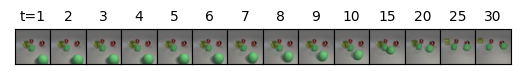

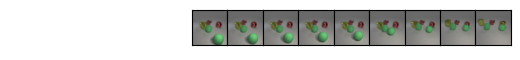

In [38]:
fig, ax = visualizations.visualize_tight_row(frames=videos[IDX], num_context=5, is_gt=True)
fig, ax = visualizations.visualize_tight_row(frames=pred_imgs[IDX], num_context=5, is_gt=False)

In [39]:
masks_categorical = masks_history[IDX].argmax(dim=1)
pred_masks_categorical = pred_masks.argmax(dim=1)

In [40]:
masks_vis = visualizations.masks_to_rgb(x=masks_categorical)
pred_masks_vis = visualizations.masks_to_rgb(x=pred_masks_categorical)

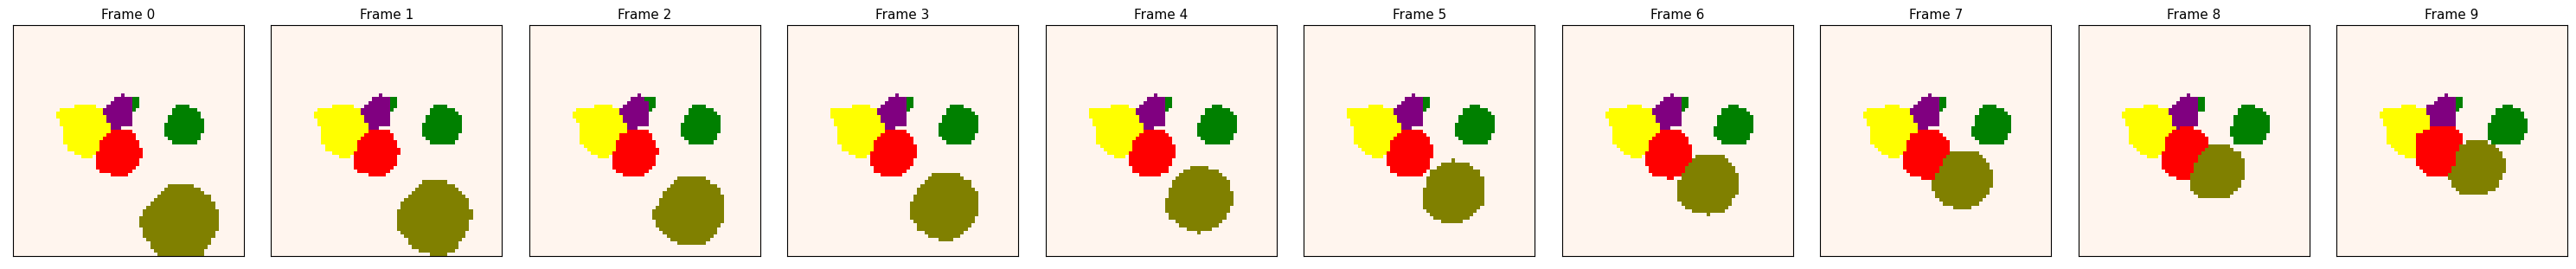

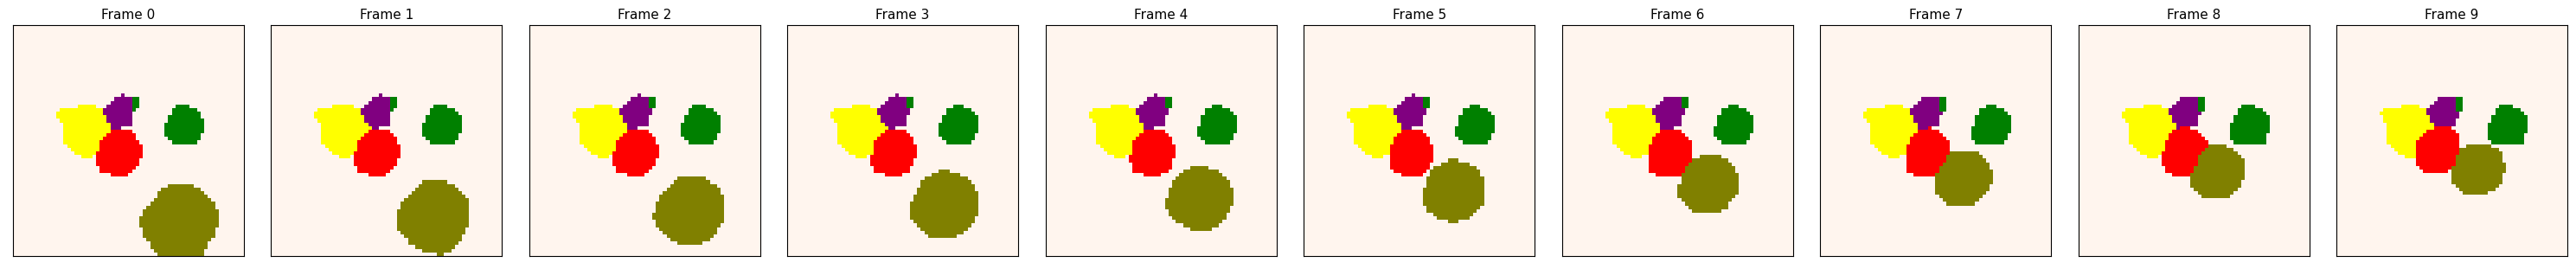

In [41]:
_ = visualizations.visualize_sequence(masks_vis[5:15, 0])
_ = visualizations.visualize_sequence(pred_masks_vis[:10, 0])

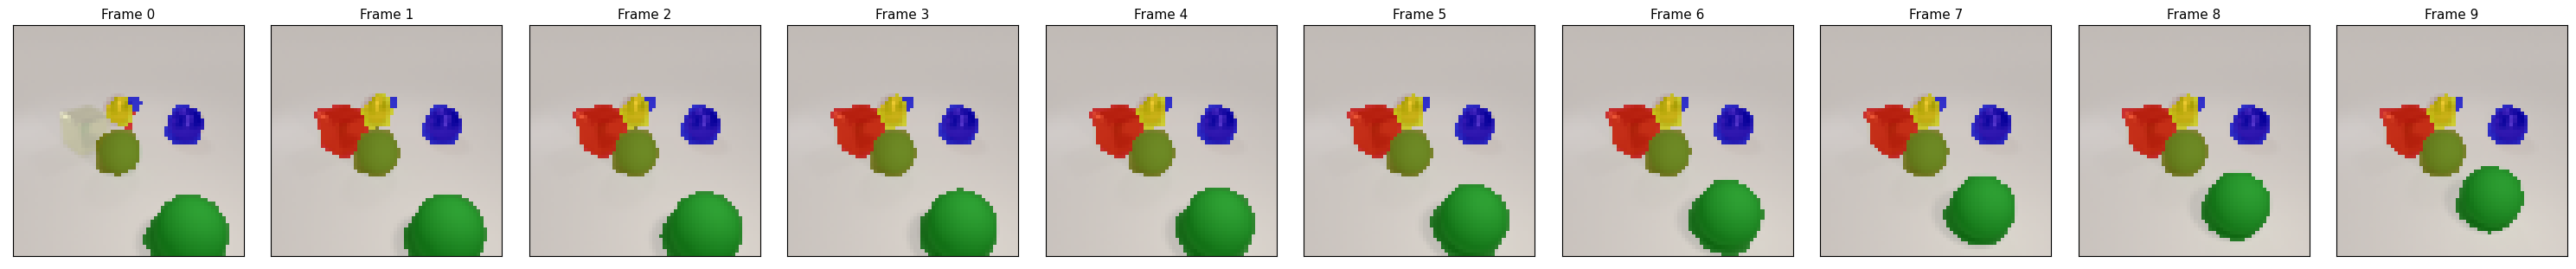

In [42]:
masks_categorical_channels = visualizations.idx_to_one_hot(x=masks_categorical)
disp_overlay = visualizations.overlay_segmentations(
        videos[IDX, :10].cpu().detach(),
        masks_categorical_channels[:10, 0].cpu().detach(),
        colors=COLORS,
        alpha=0.6
    )

_ = visualizations.visualize_sequence(disp_overlay[:10])

In [46]:
pred_masks.shape

torch.Size([25, 6, 1, 64, 64])

/home/data/user/villar/ObjectCentricVideoPred/src/lib/visualizations.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(n_rows, n_cols)


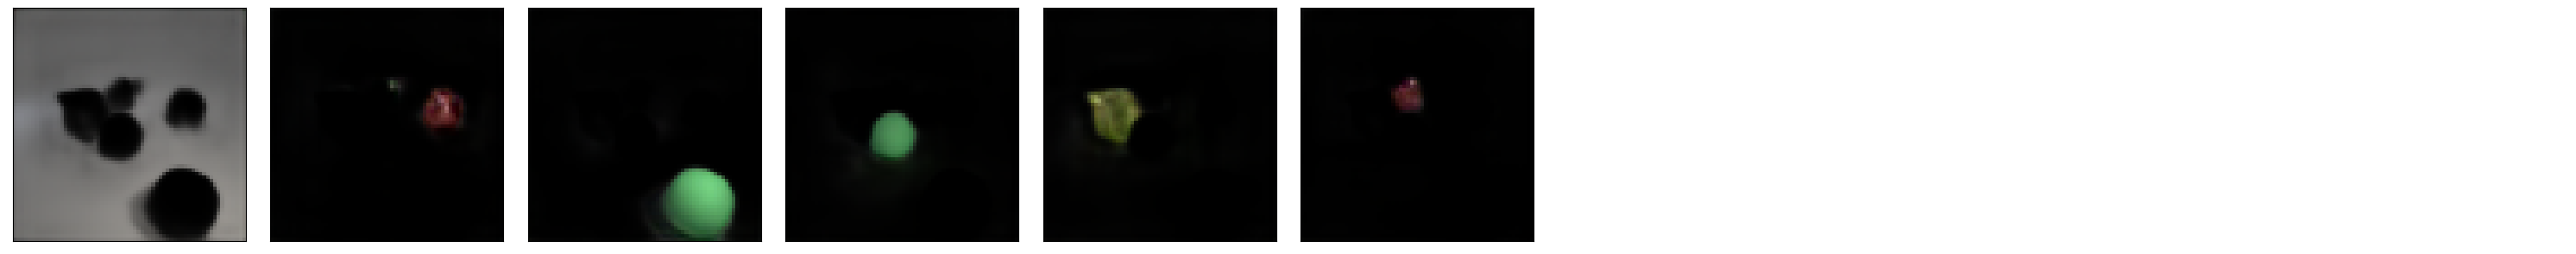

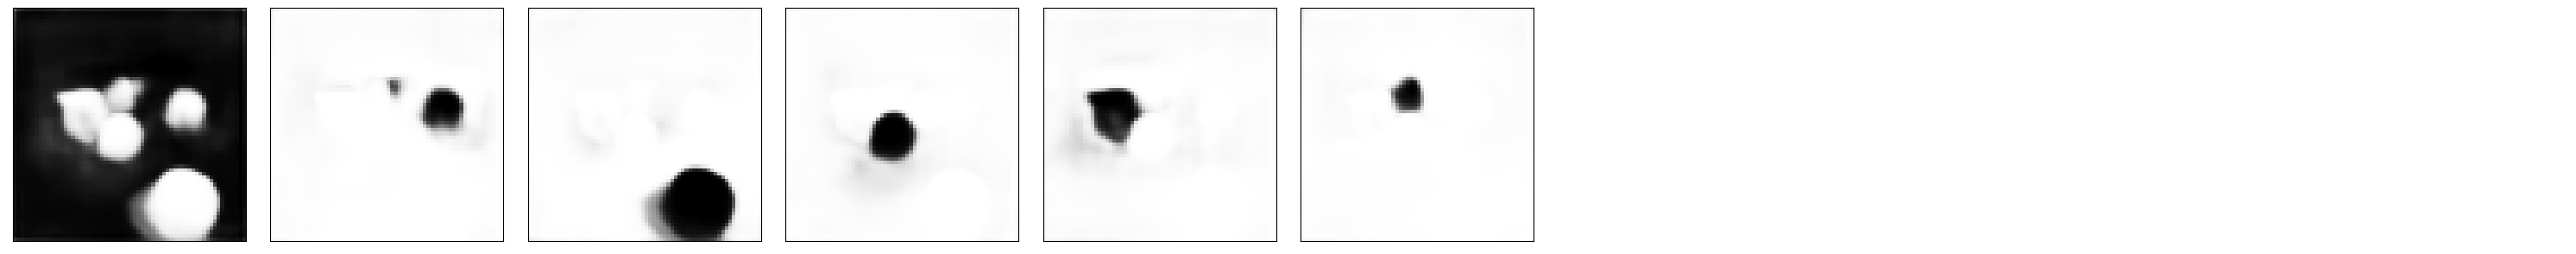

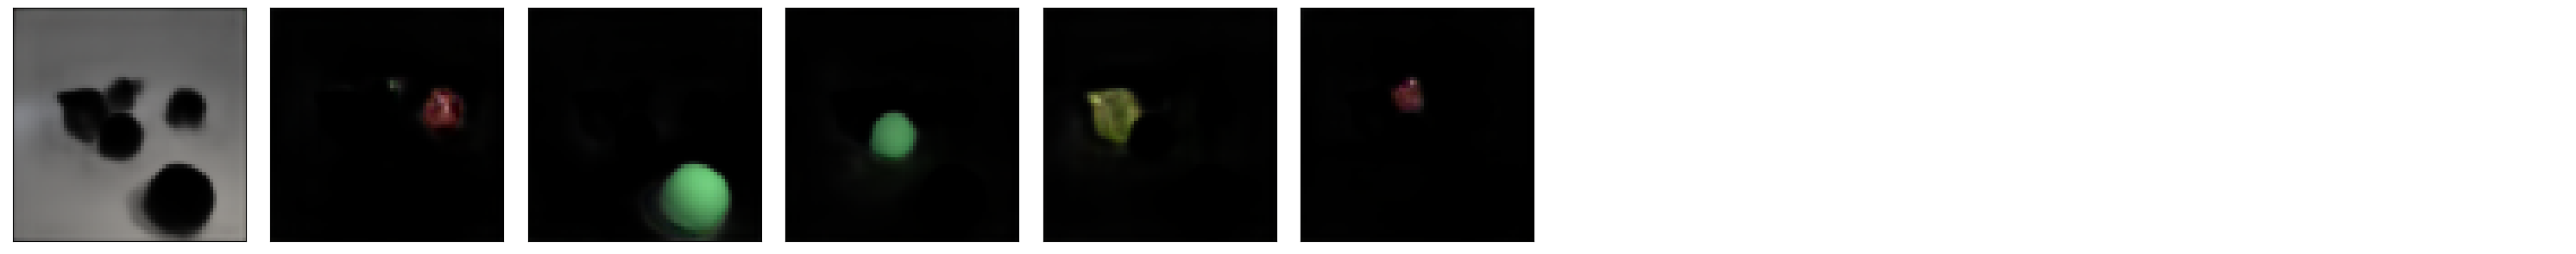

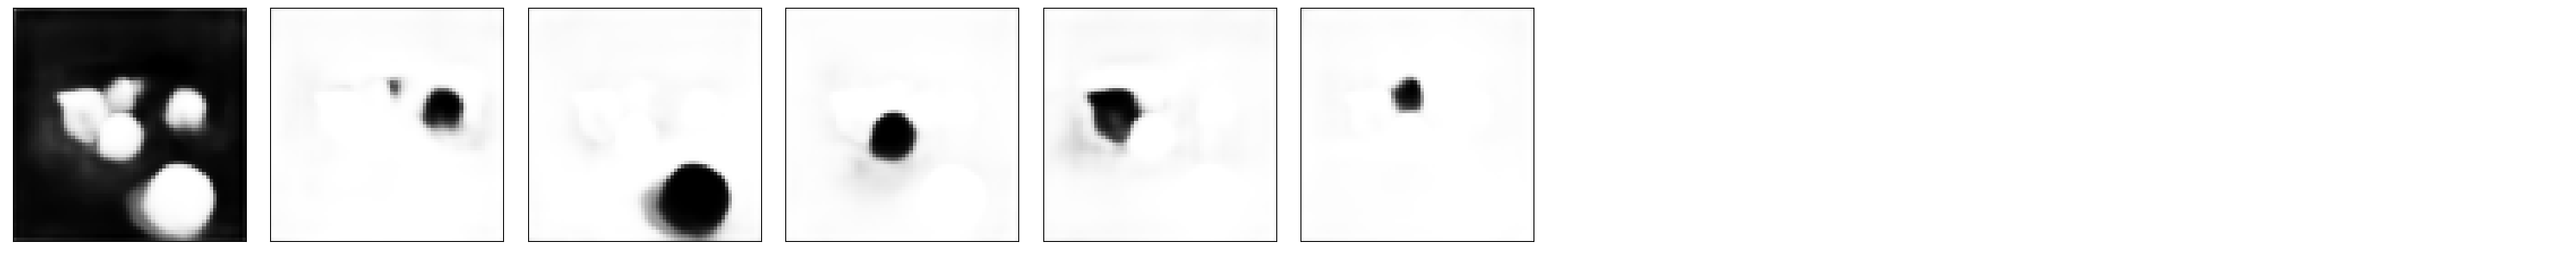

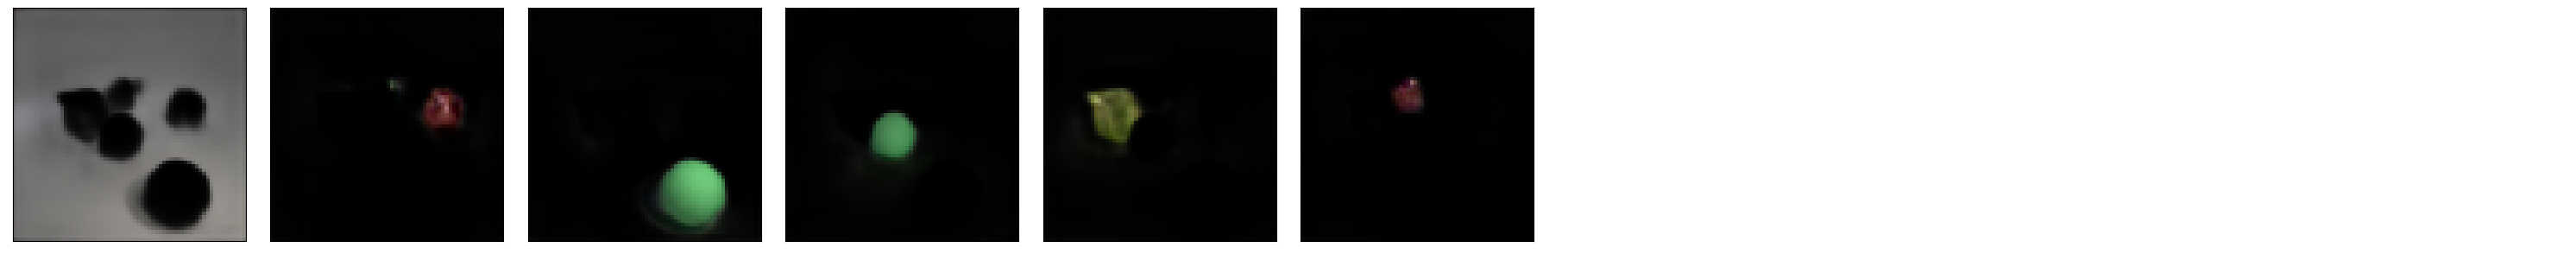

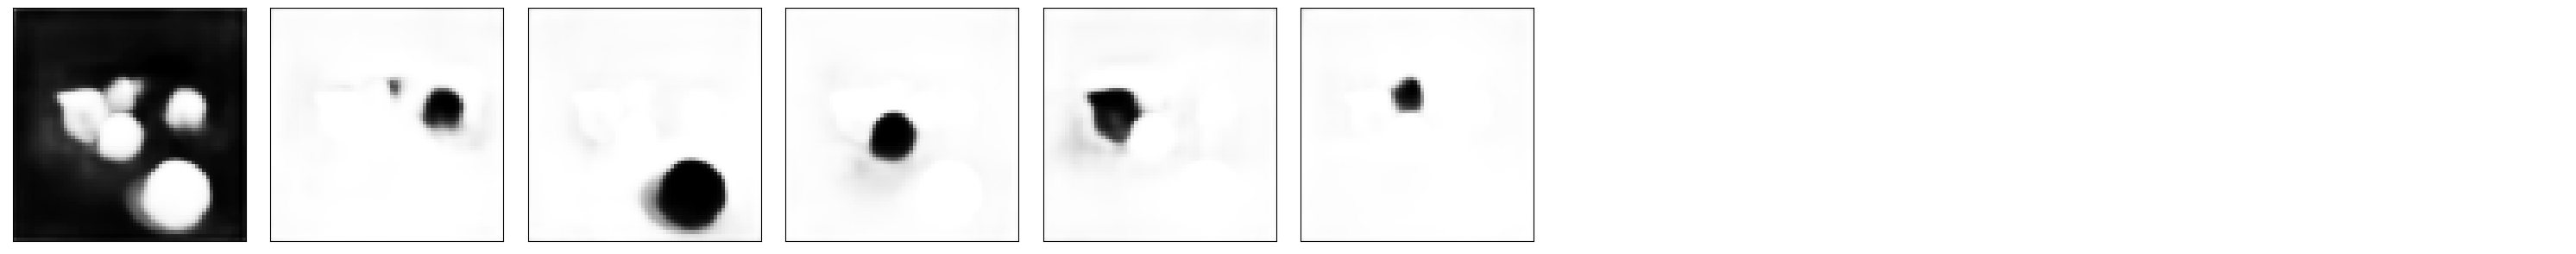

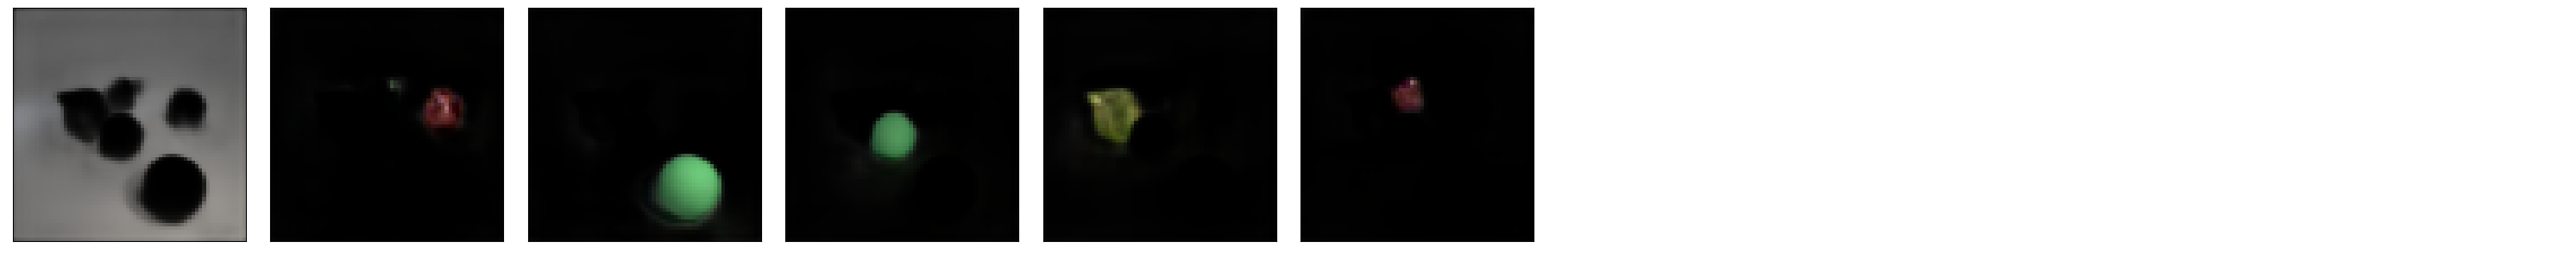

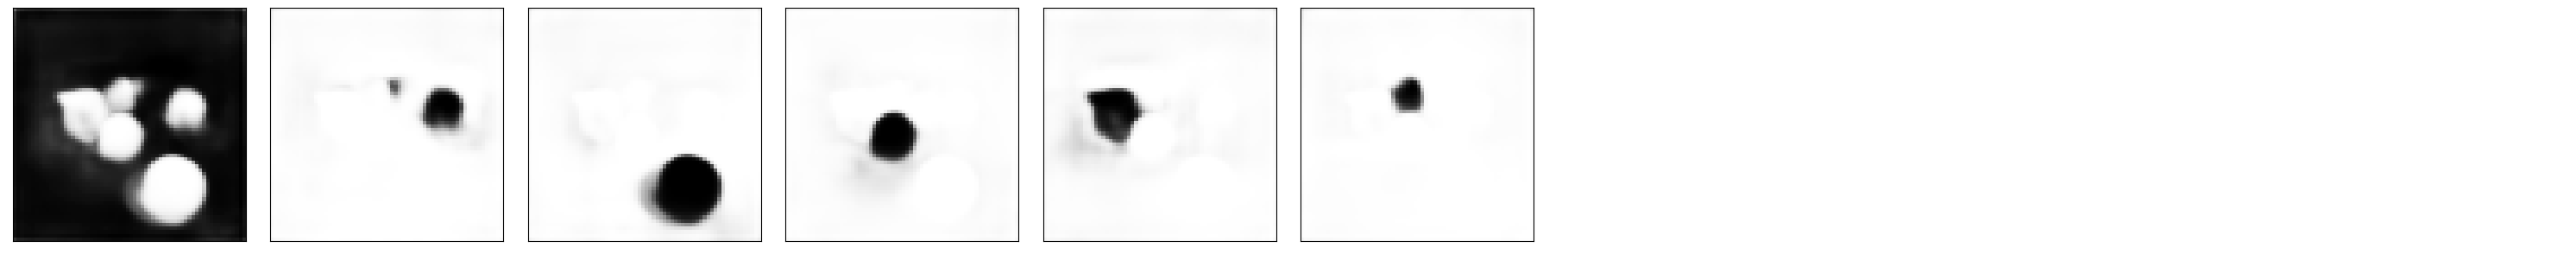

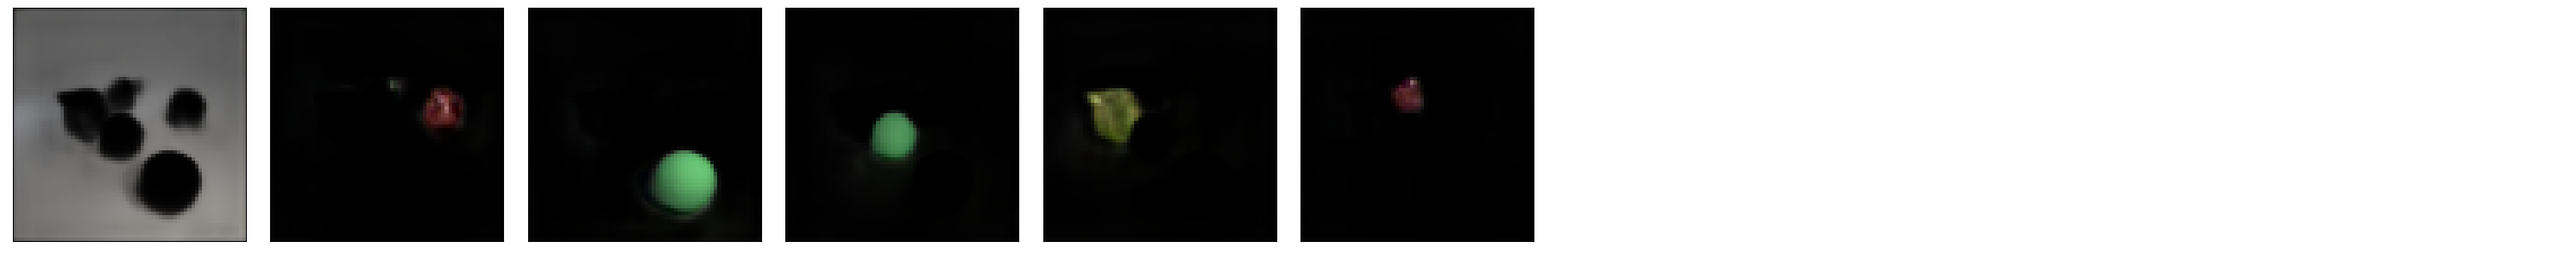

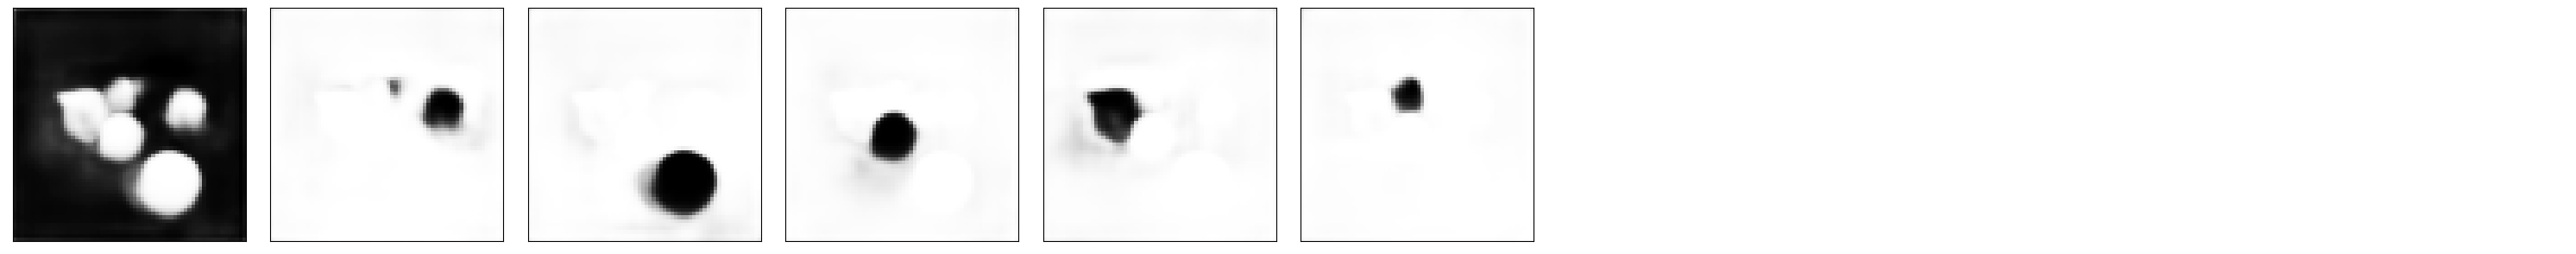

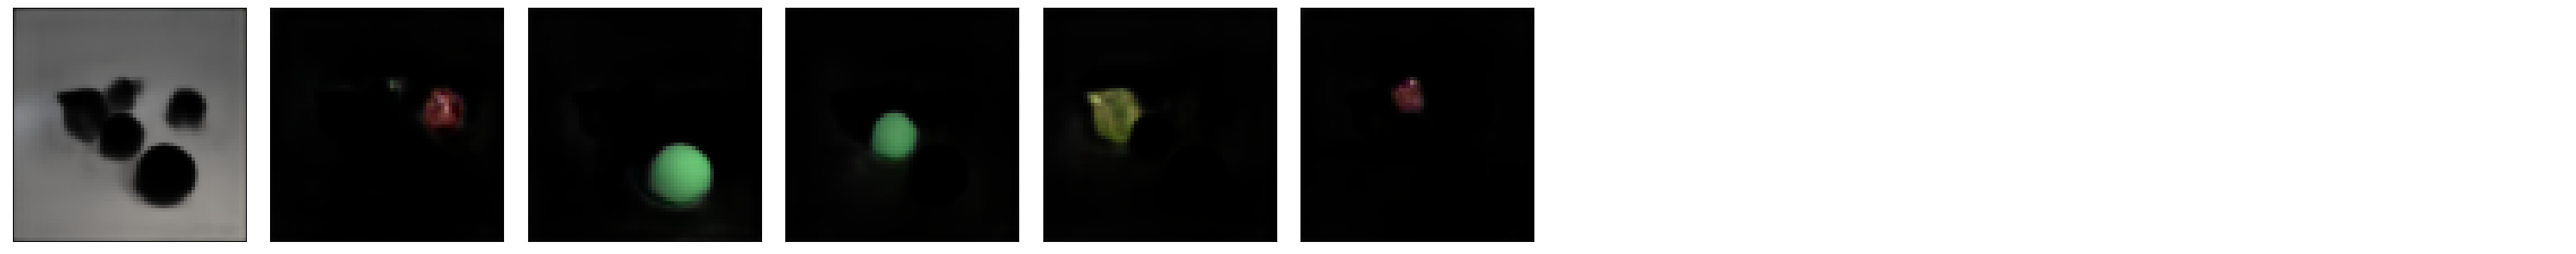

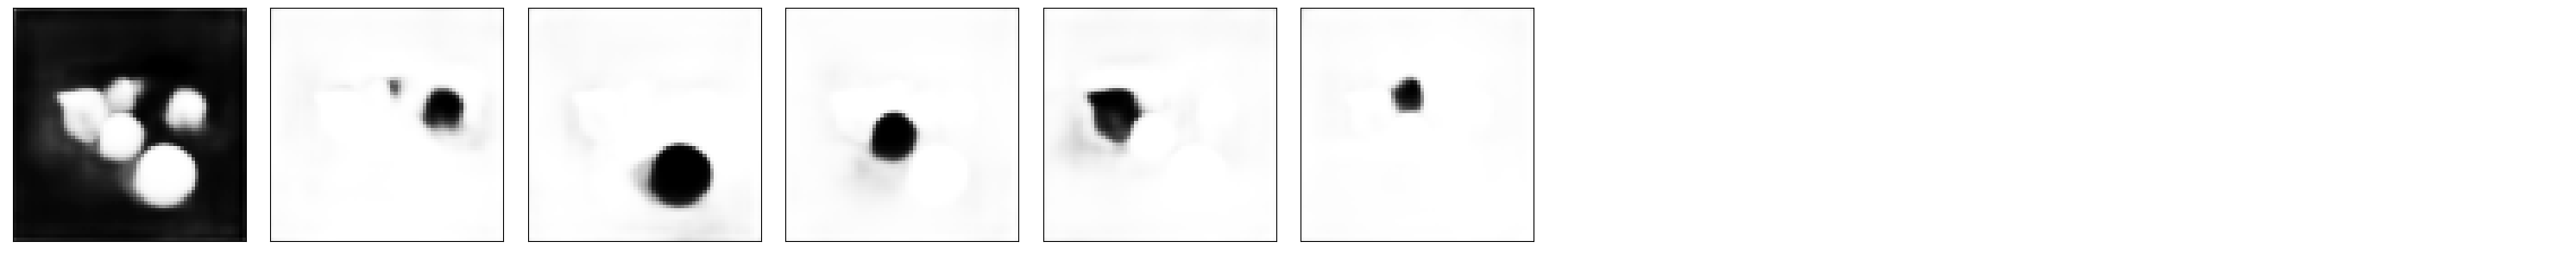

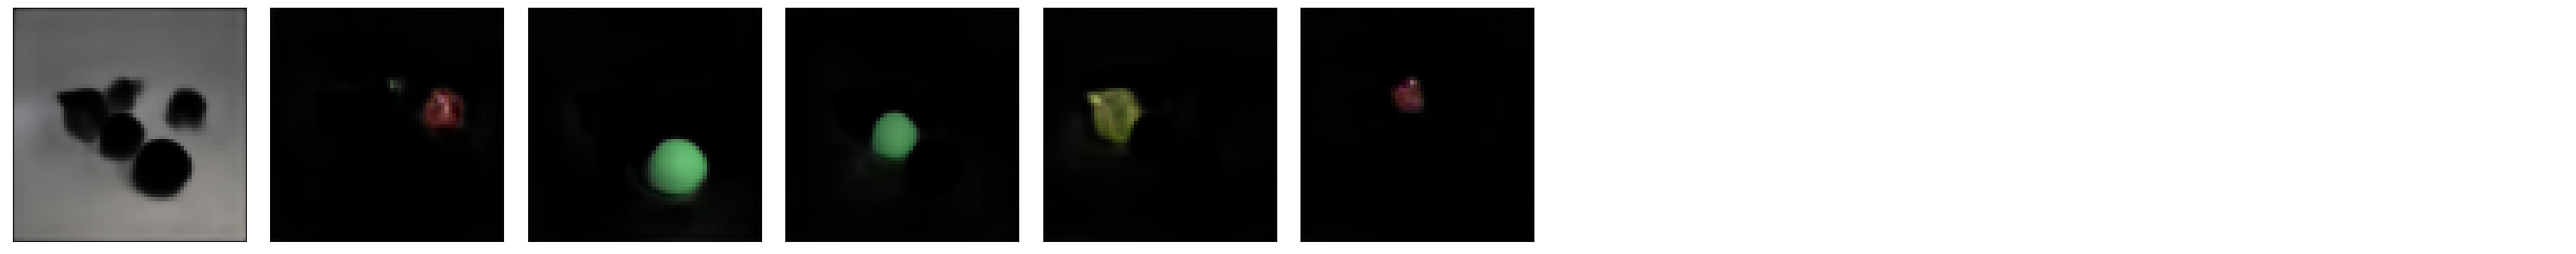

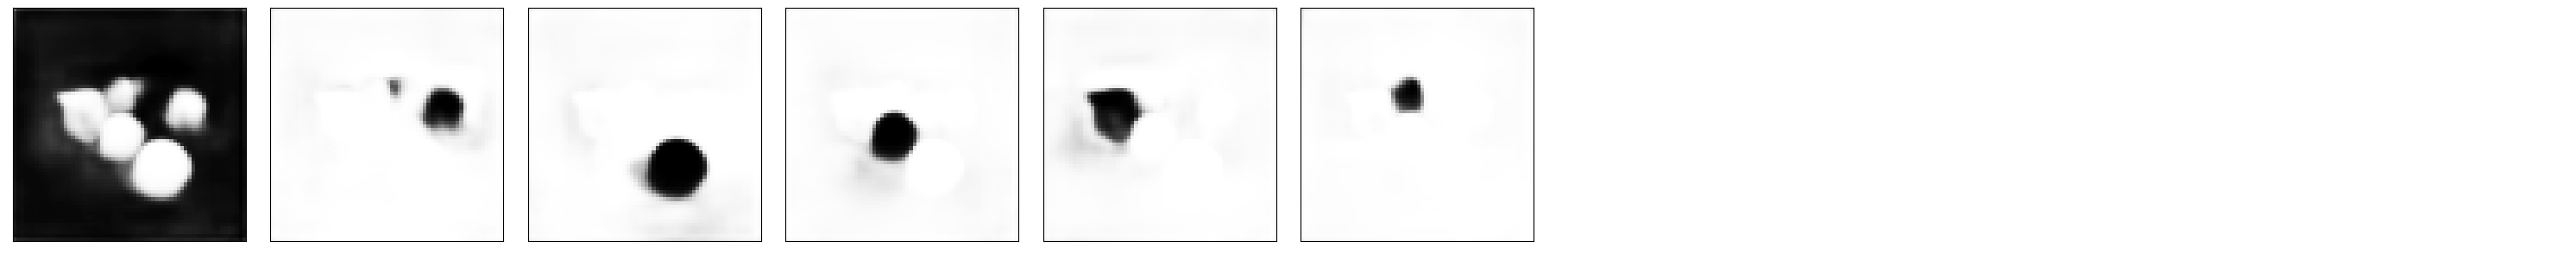

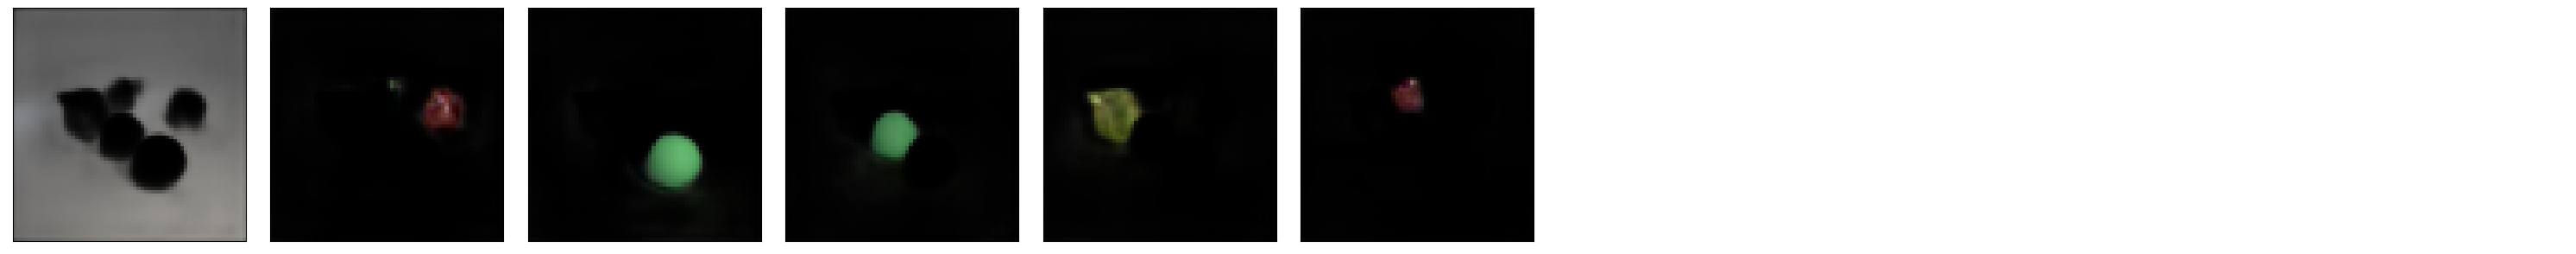

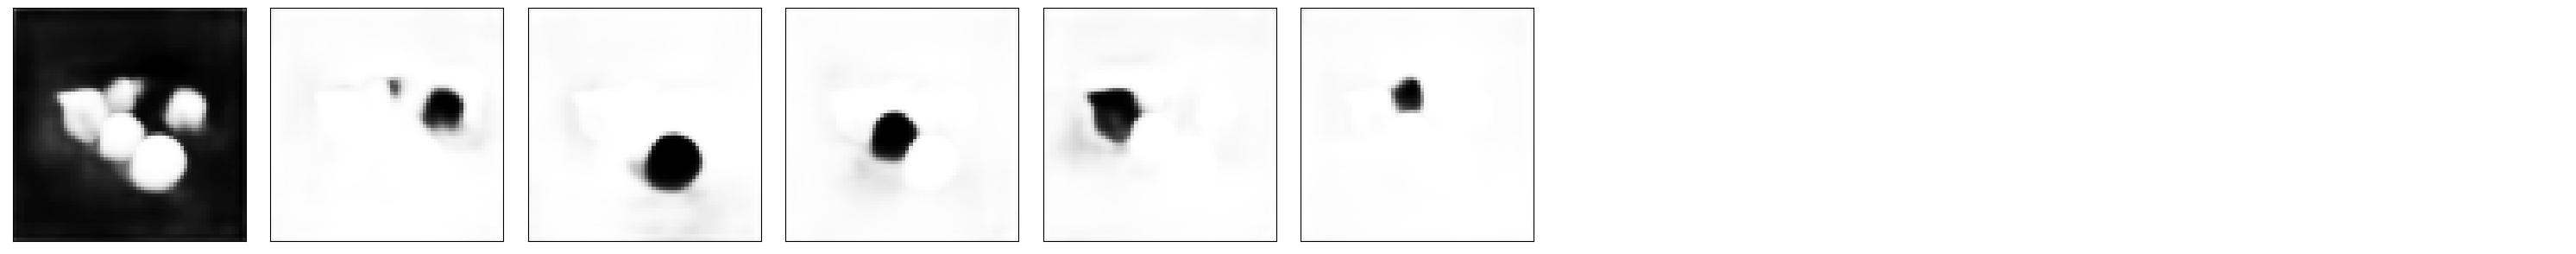

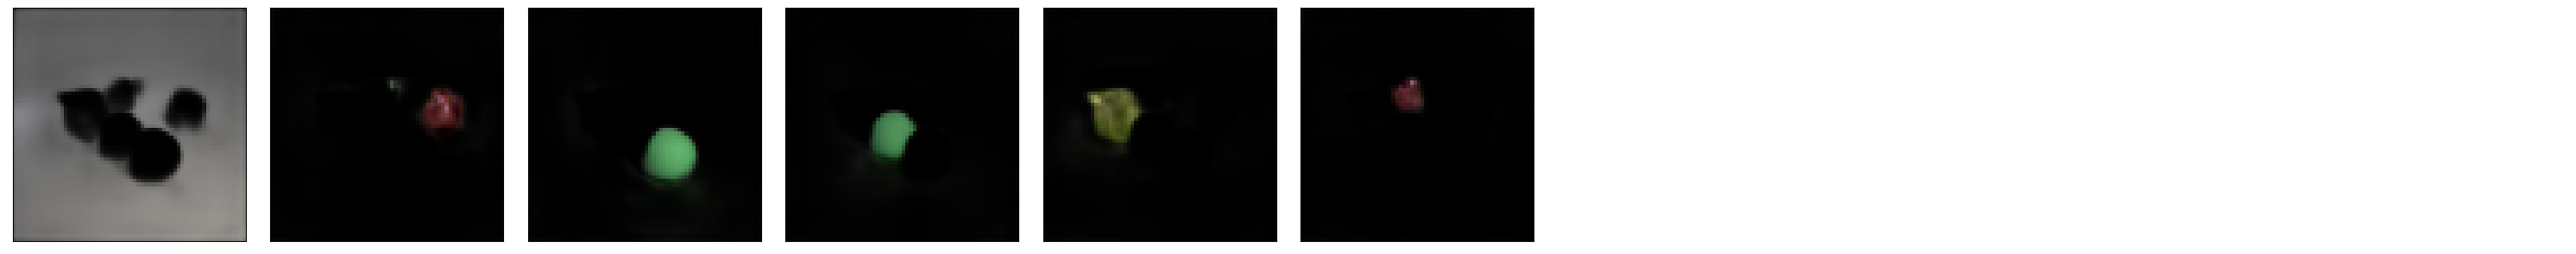

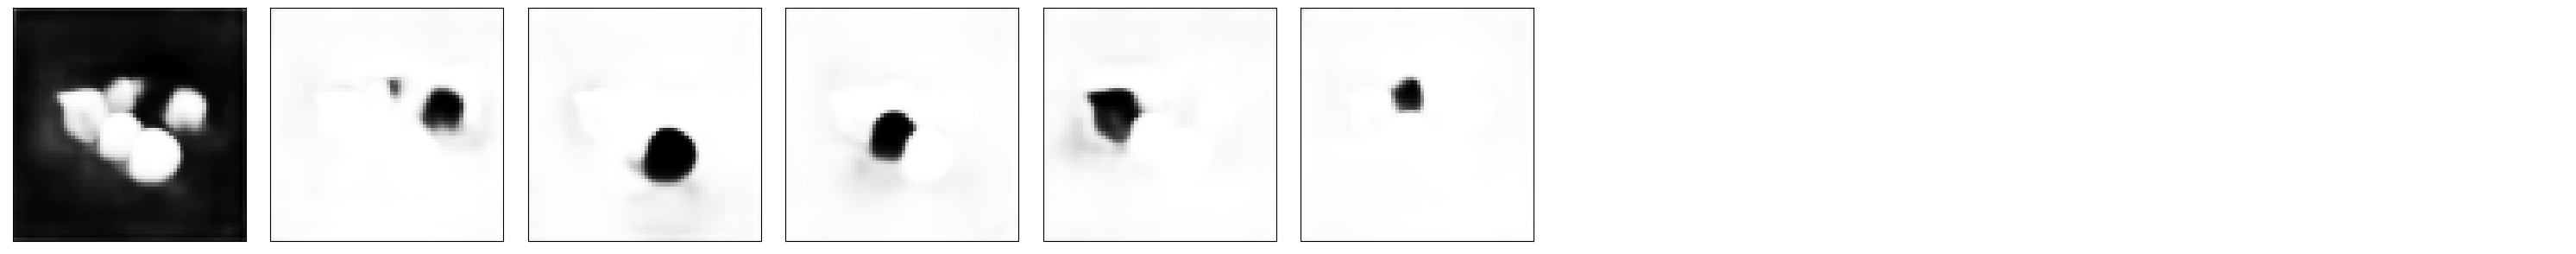

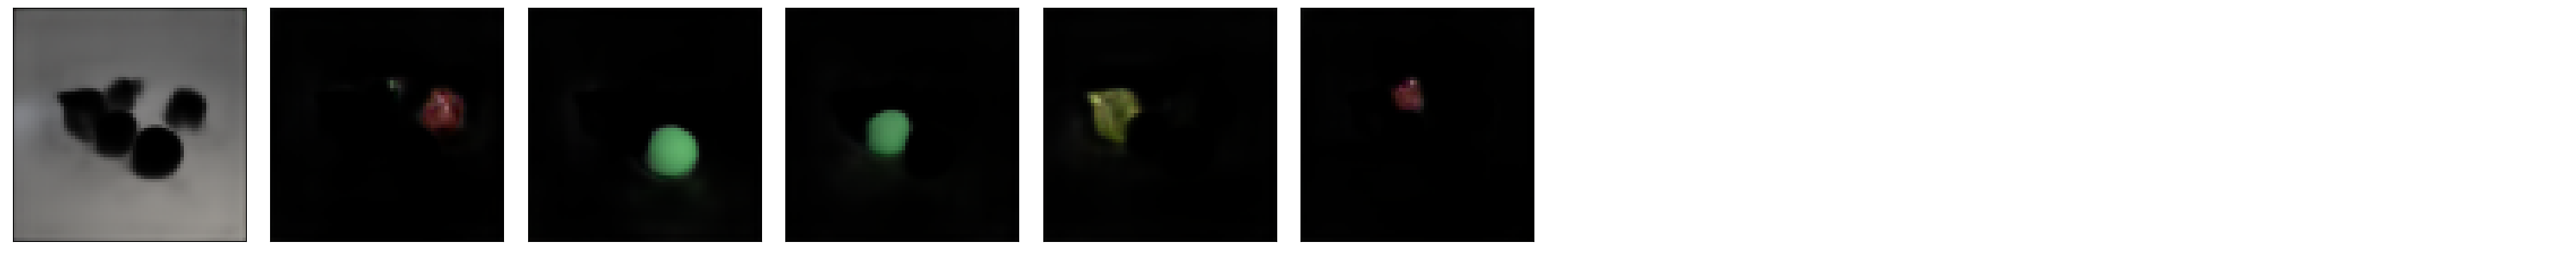

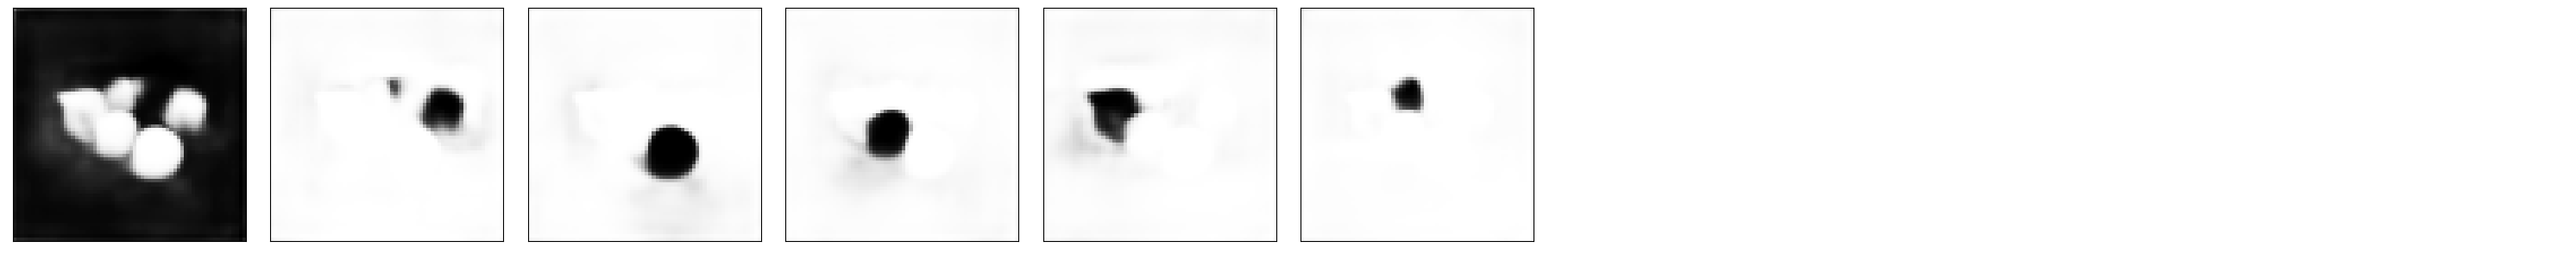

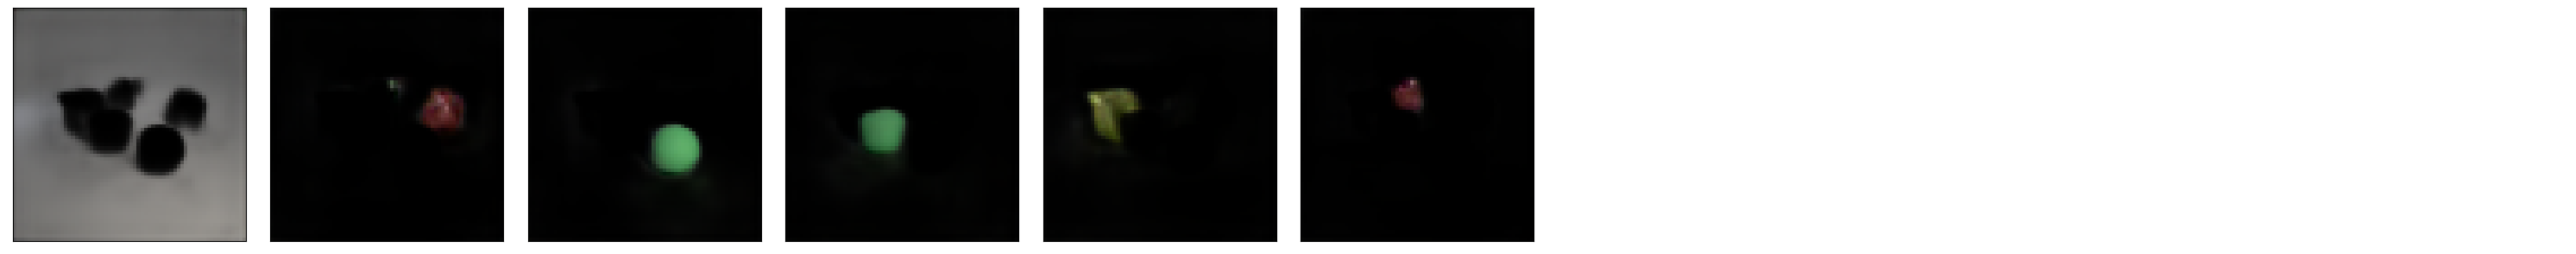

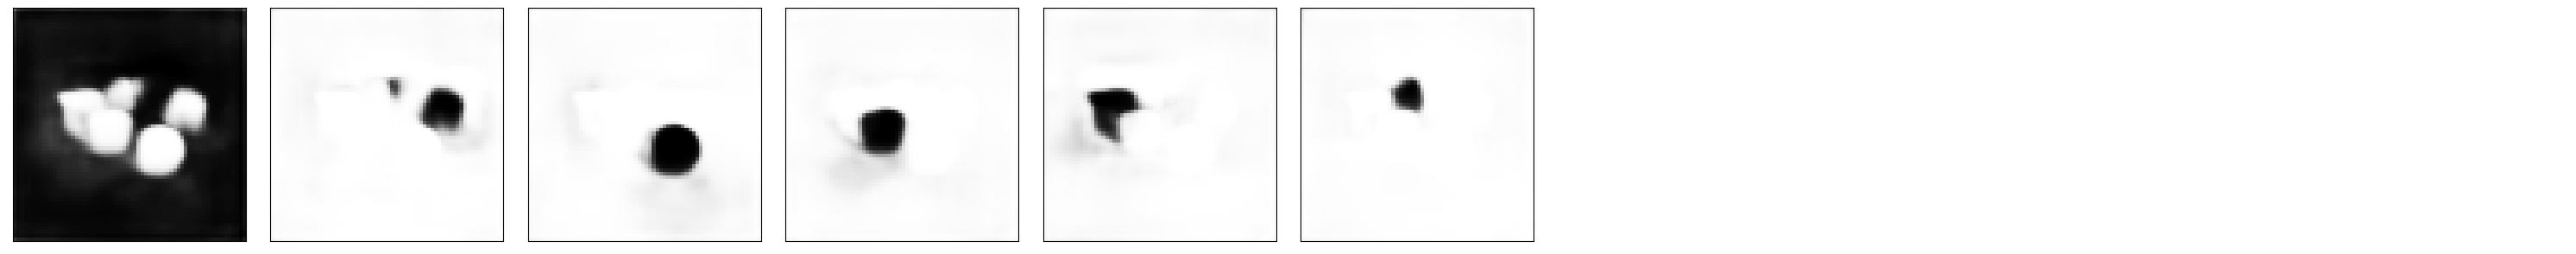

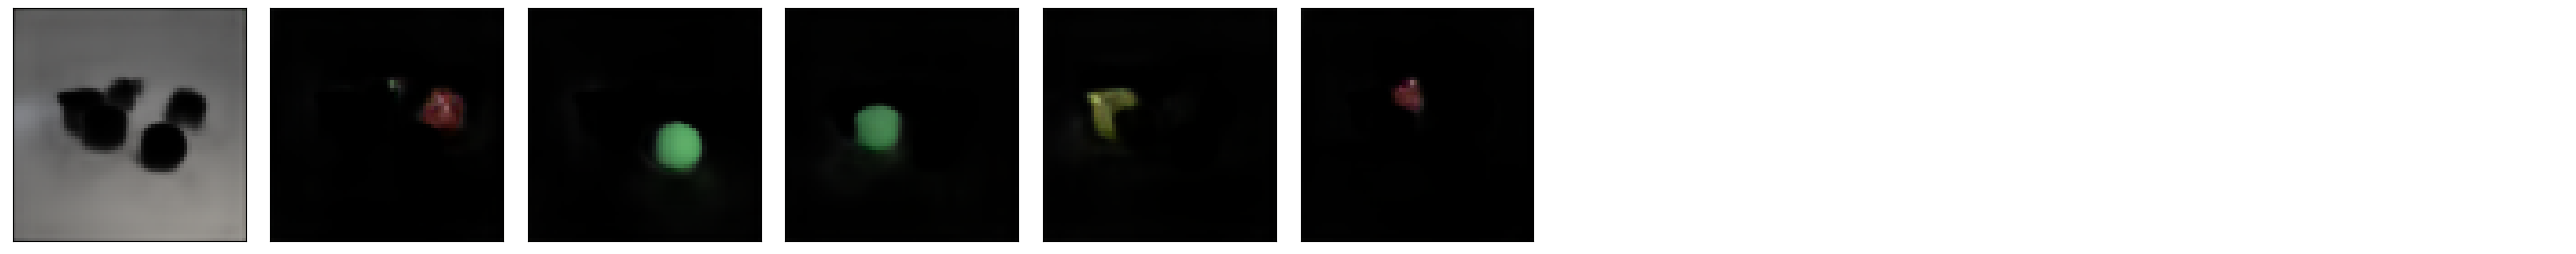

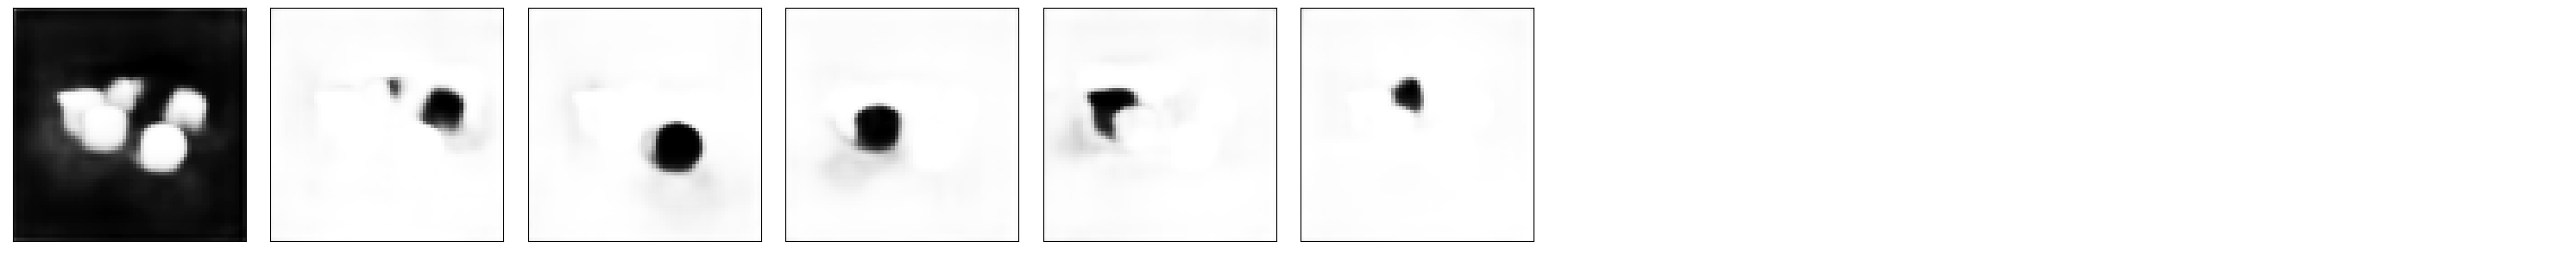

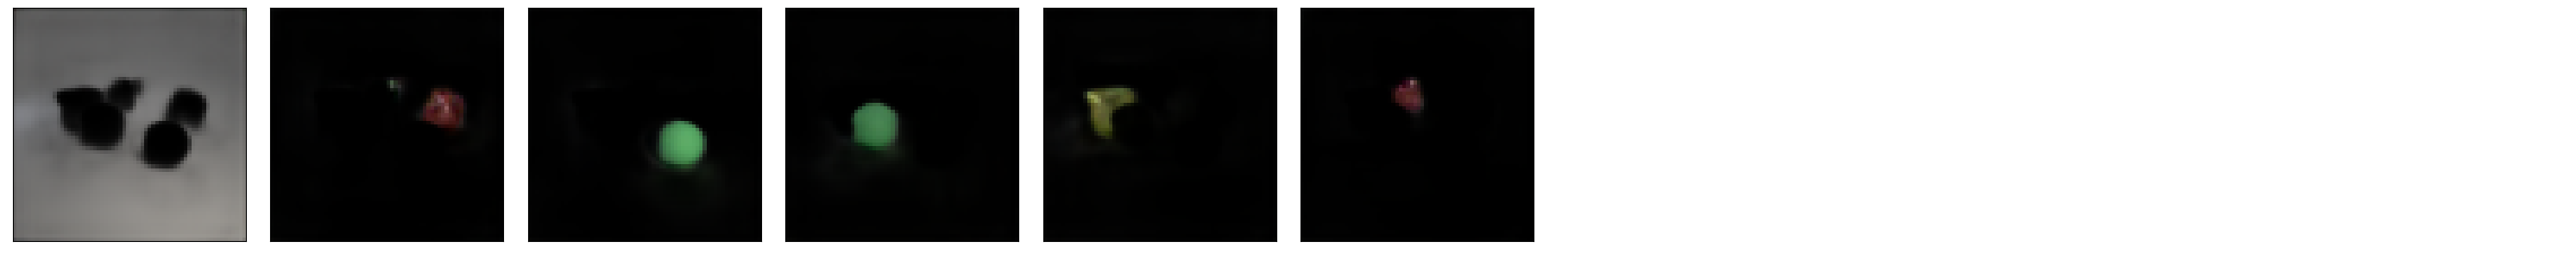

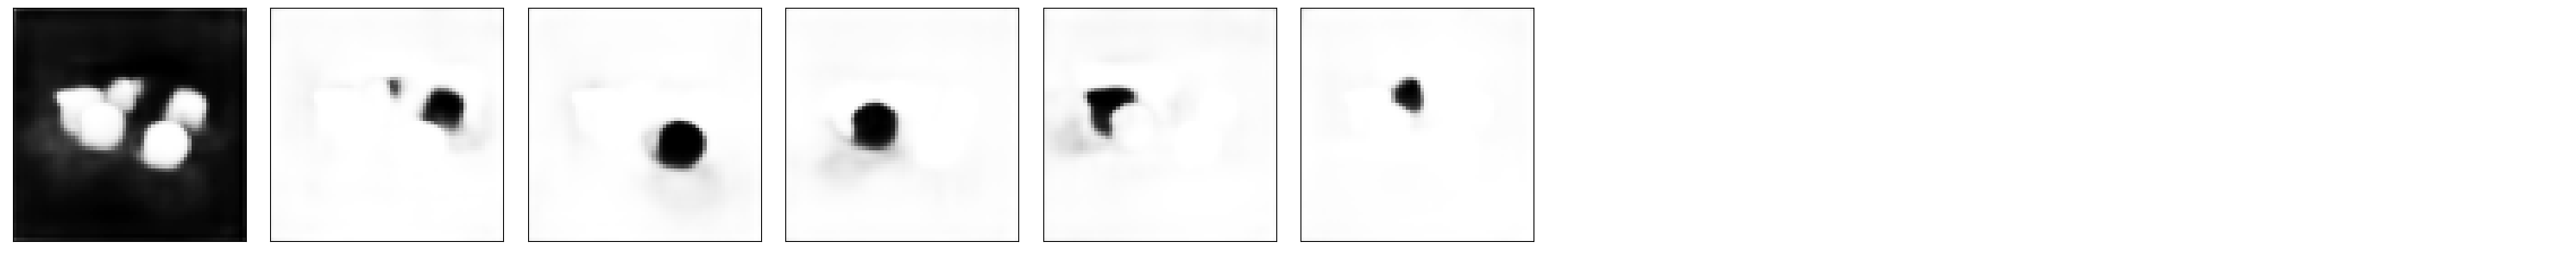

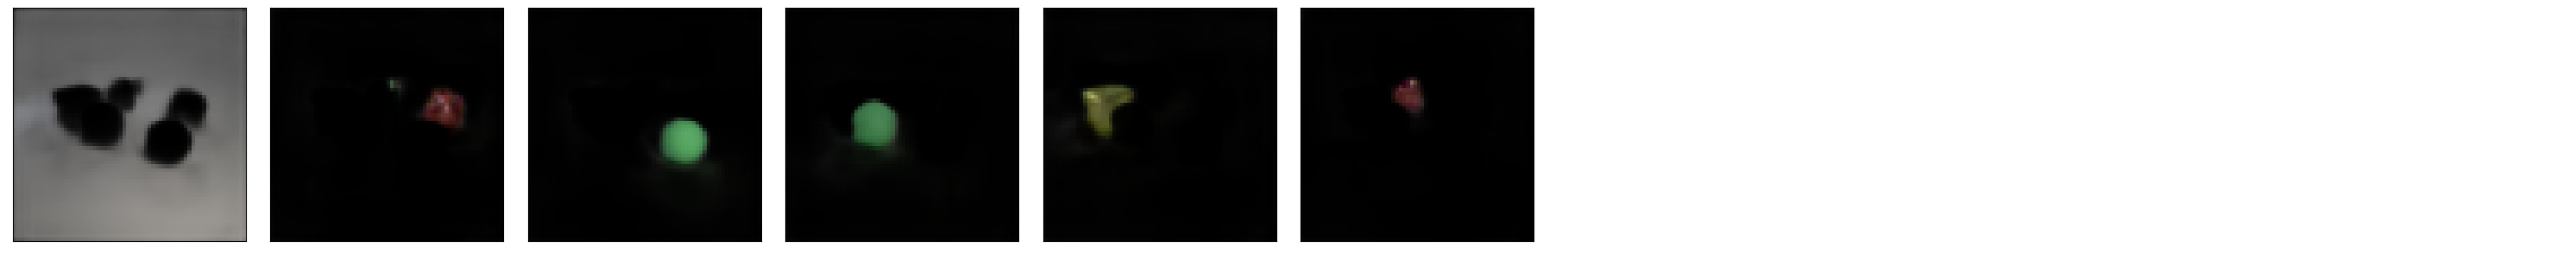

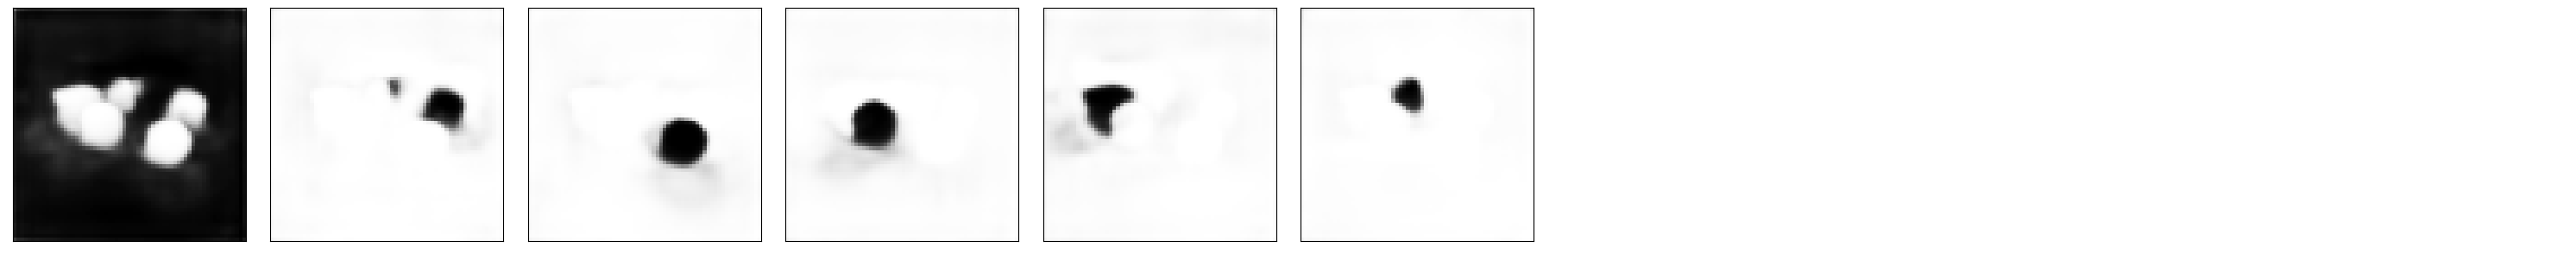

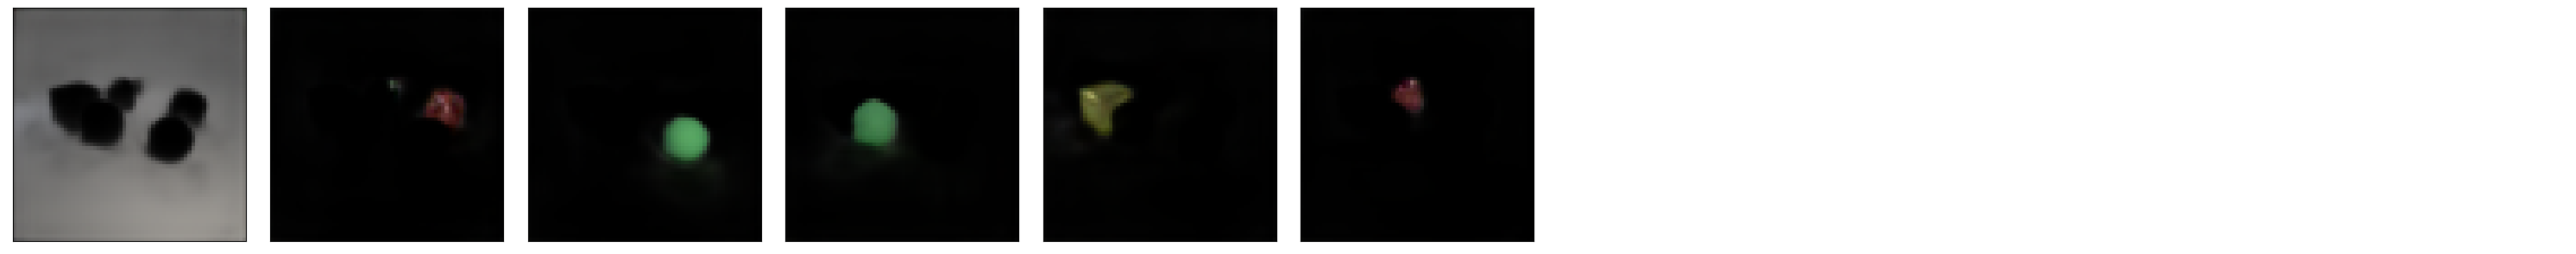

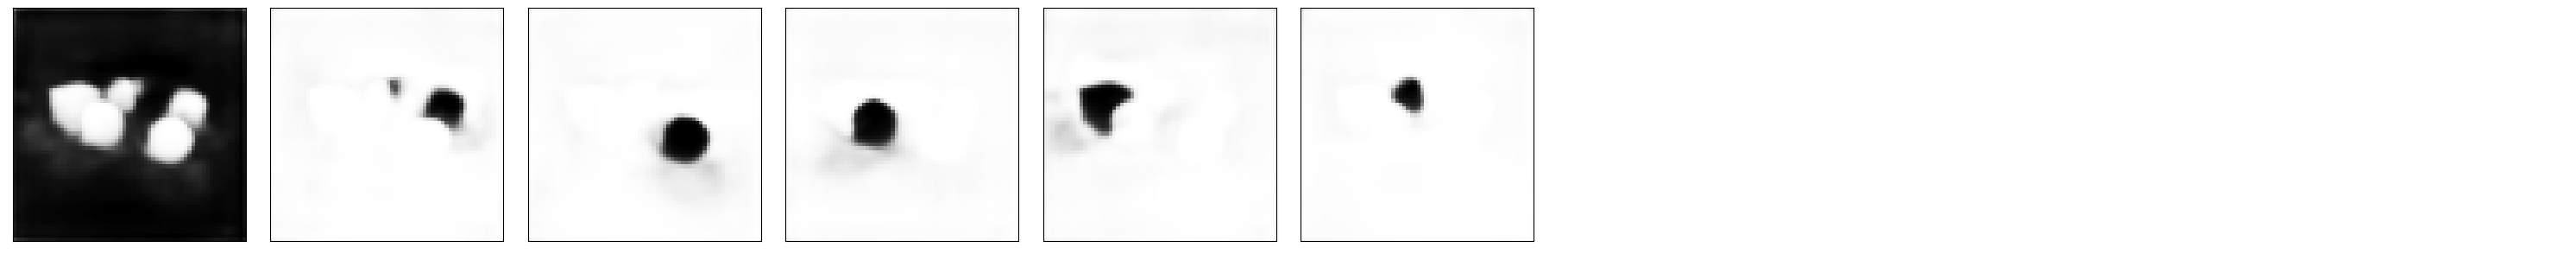

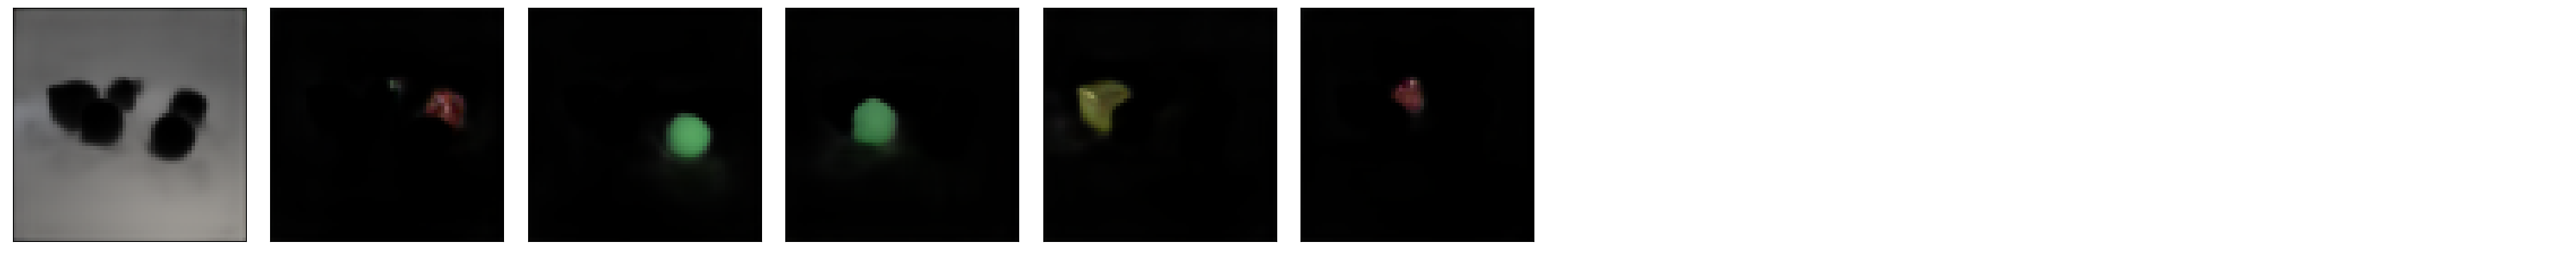

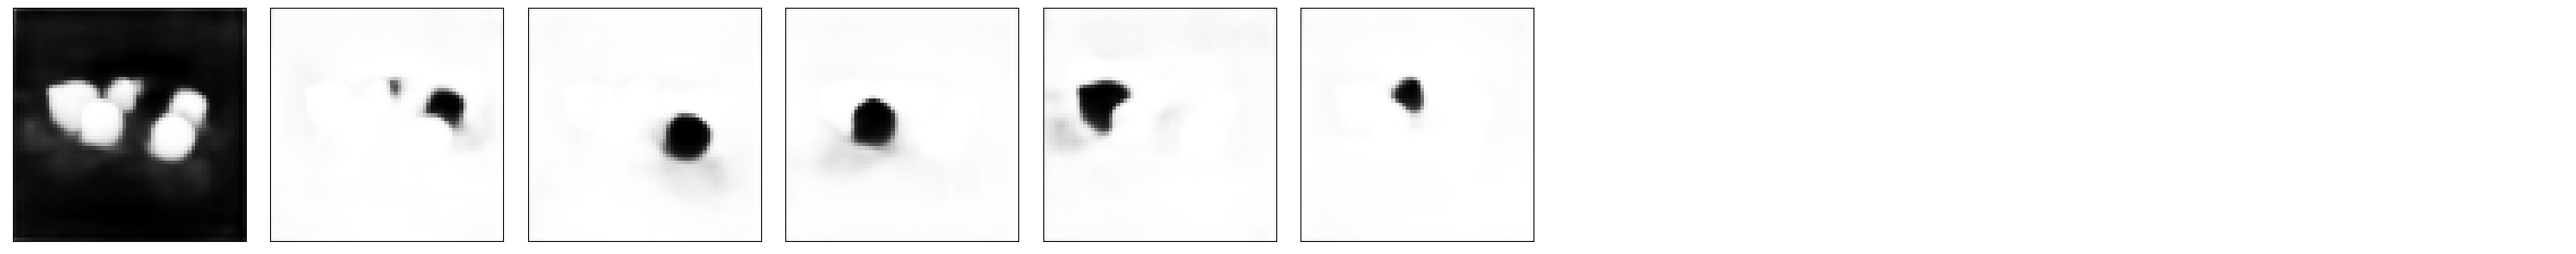

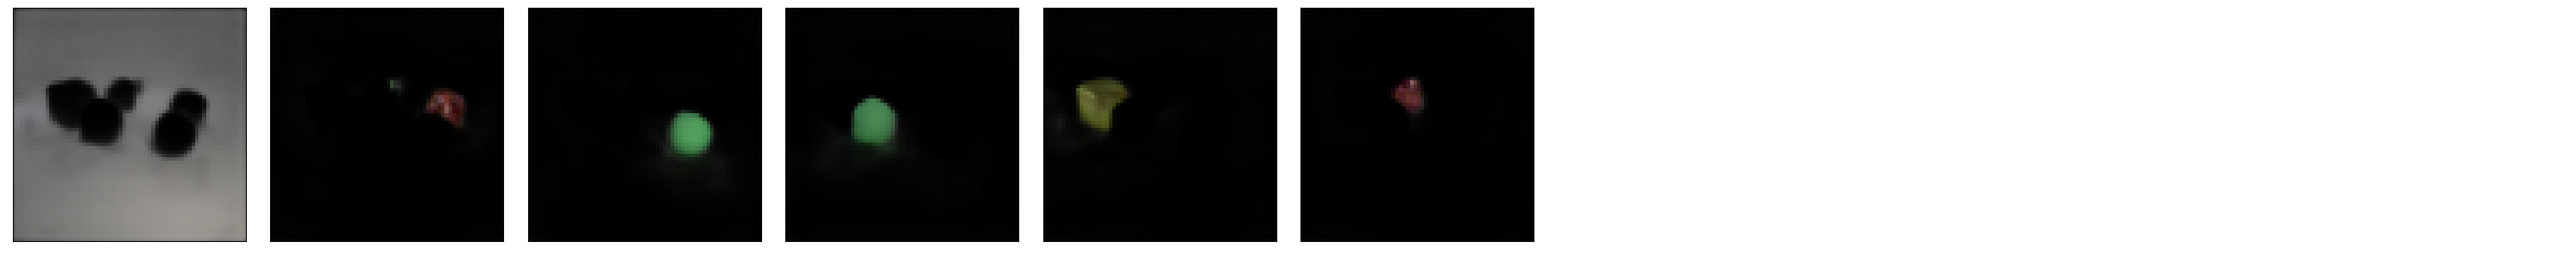

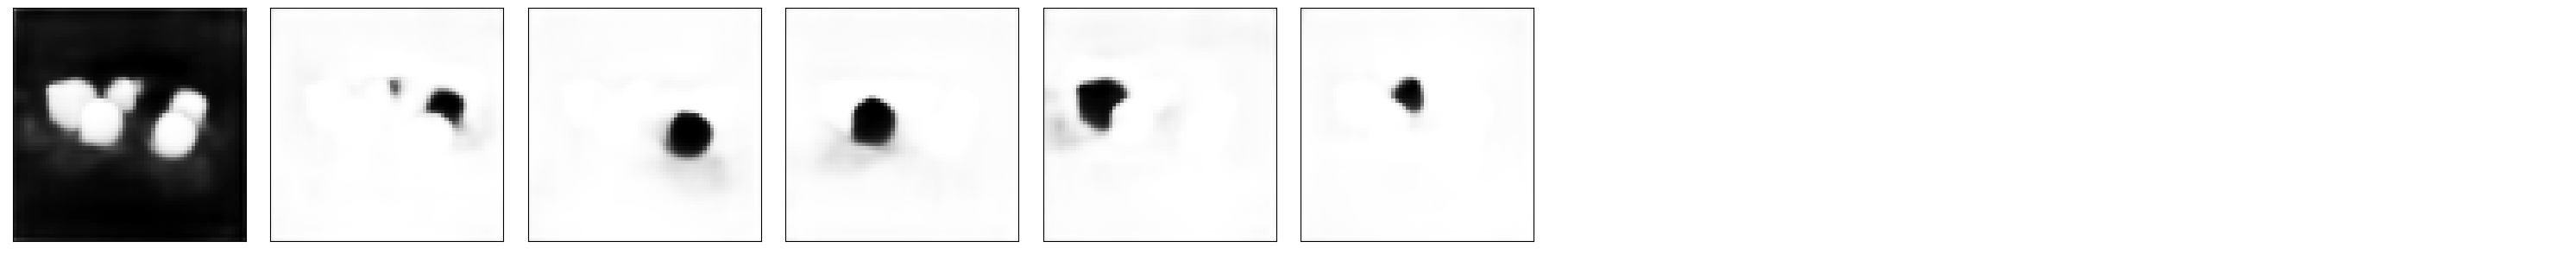

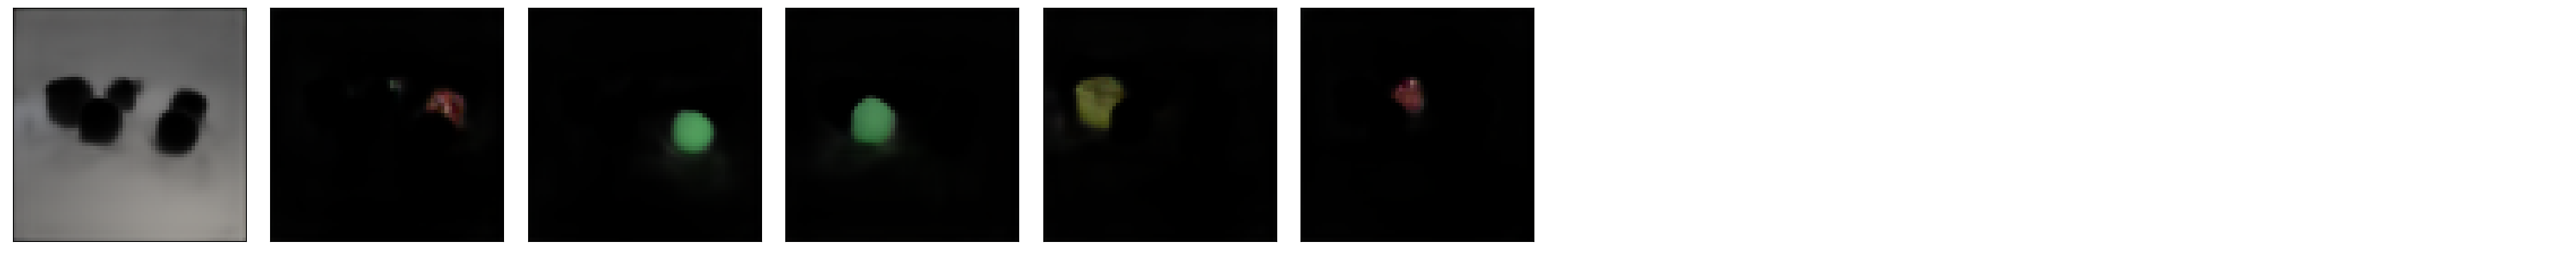

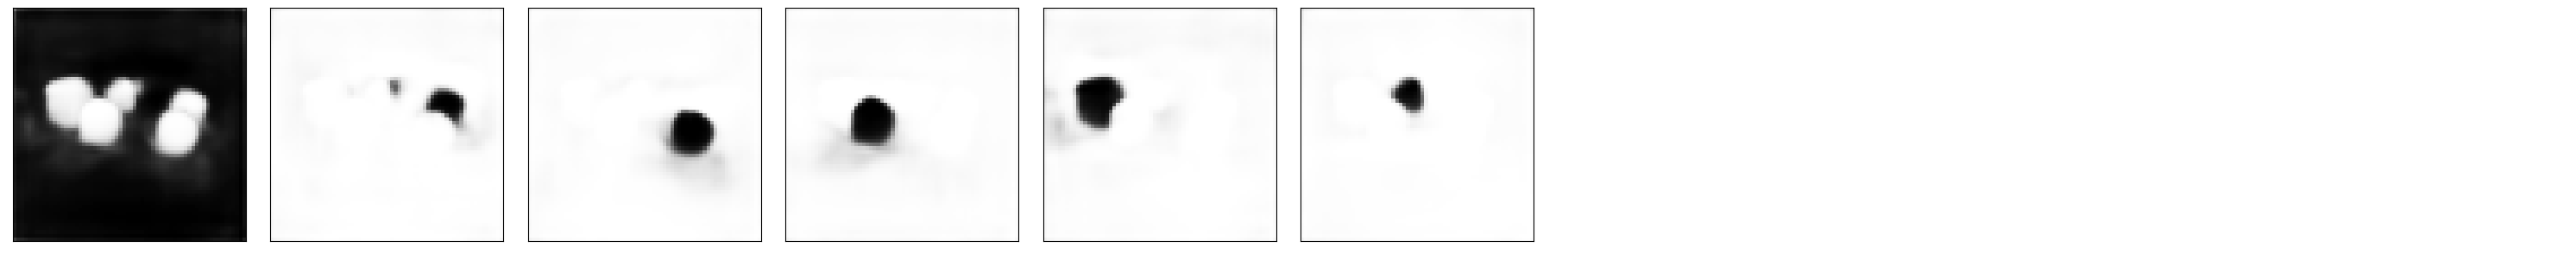

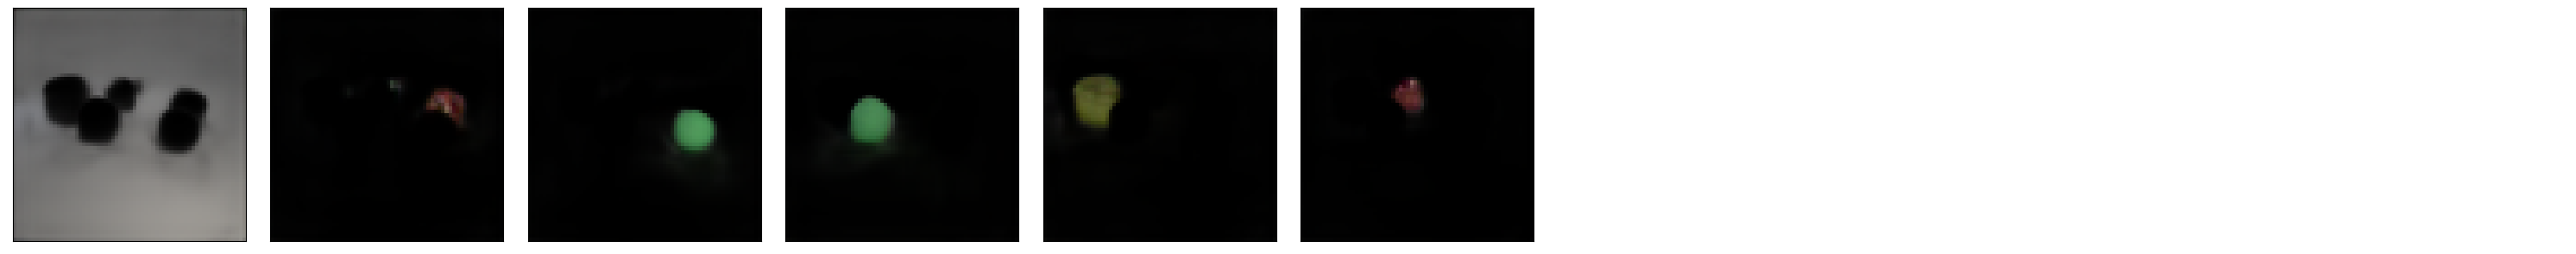

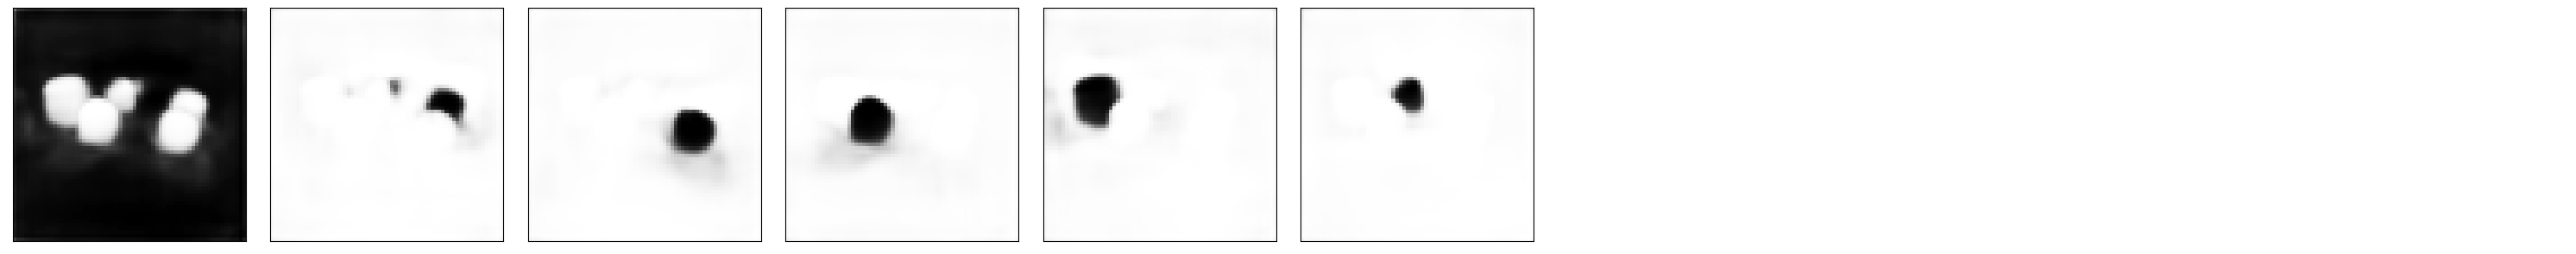

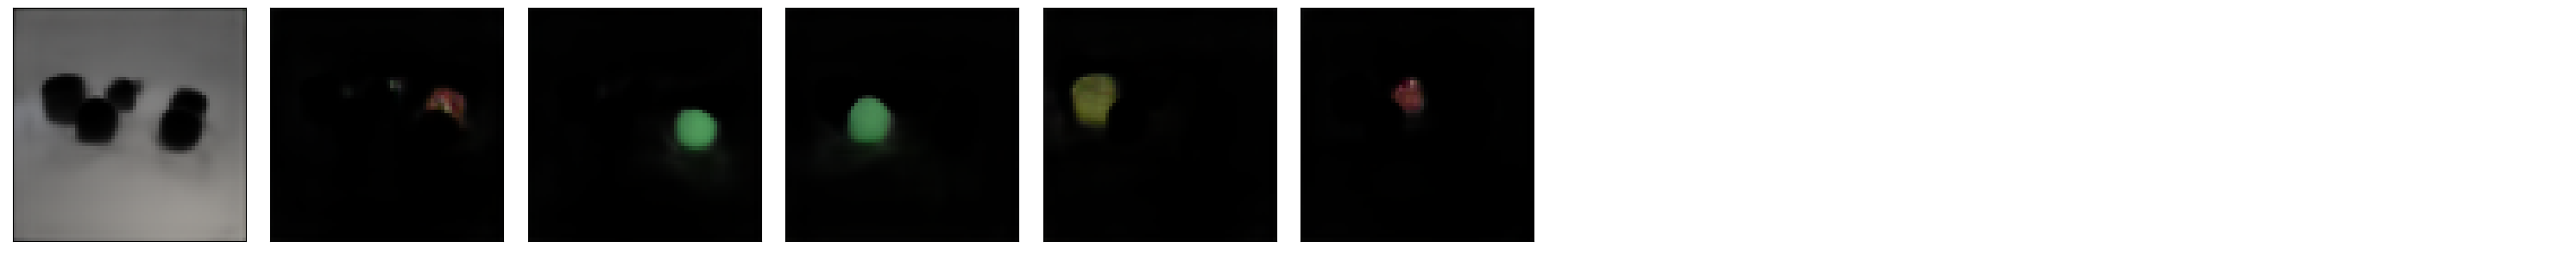

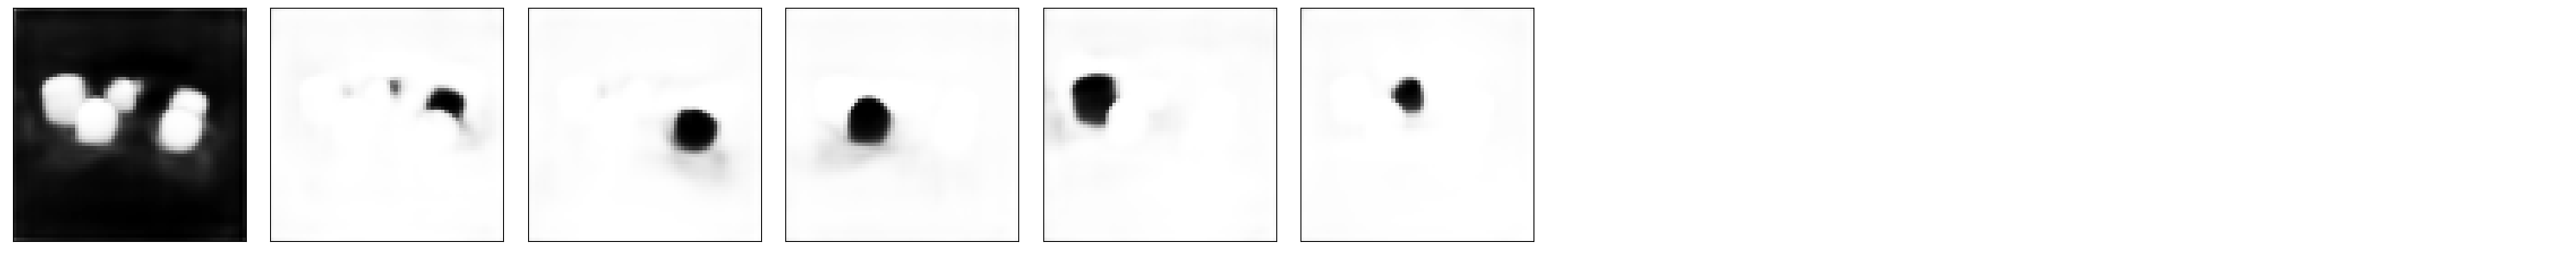

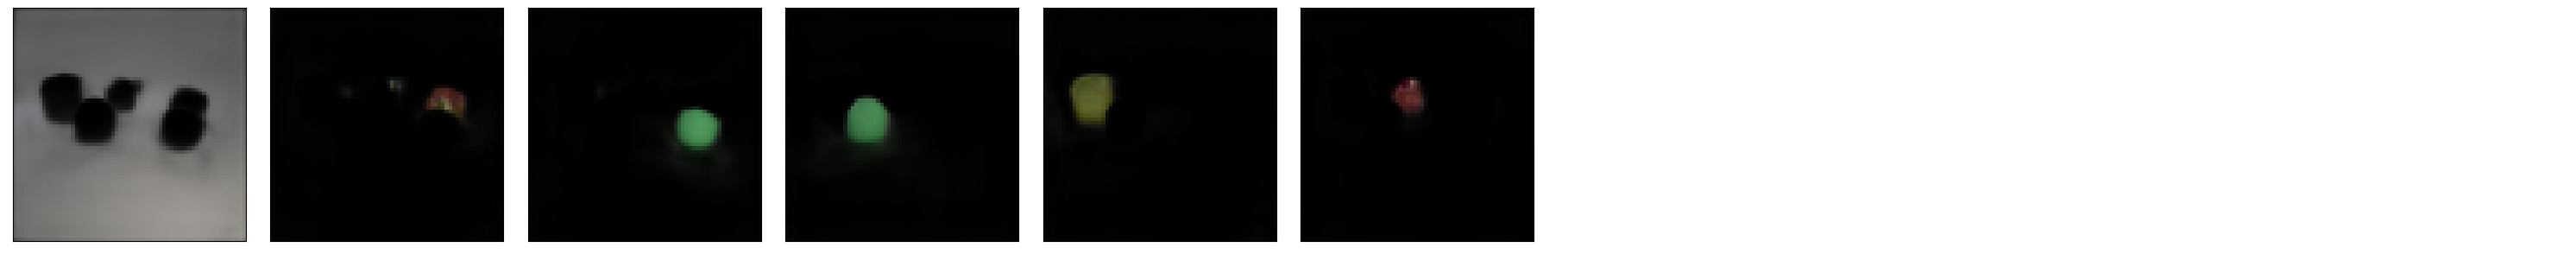

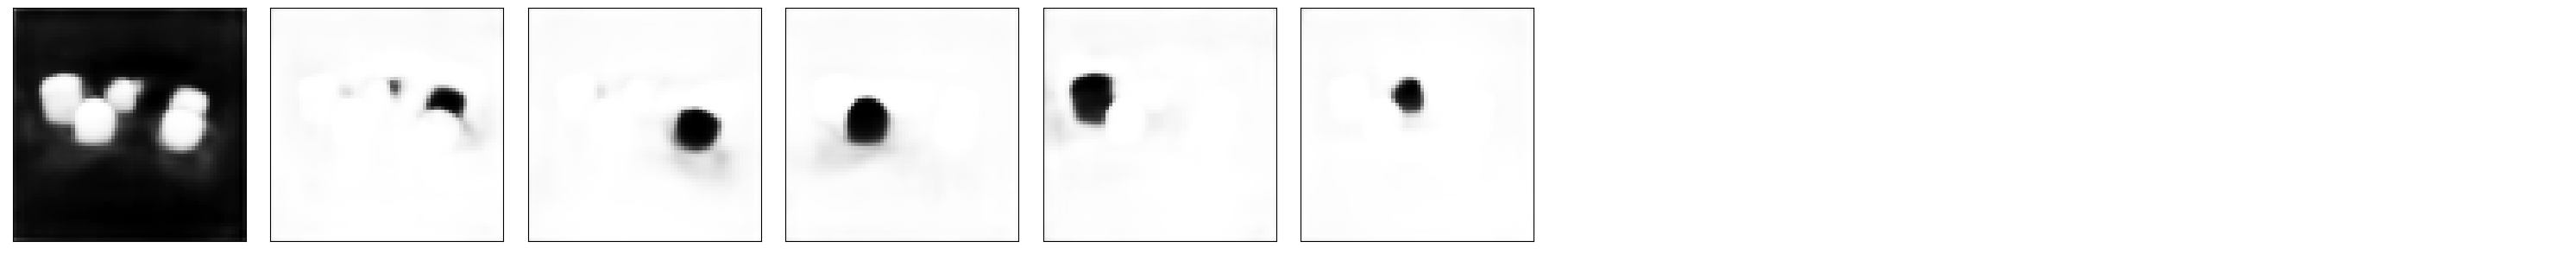

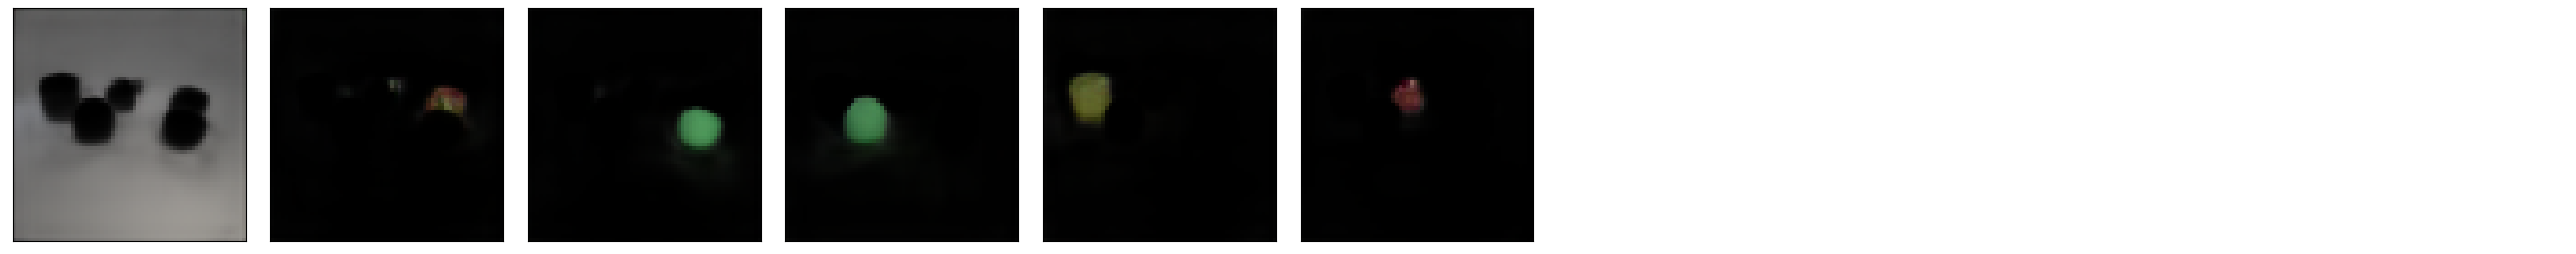

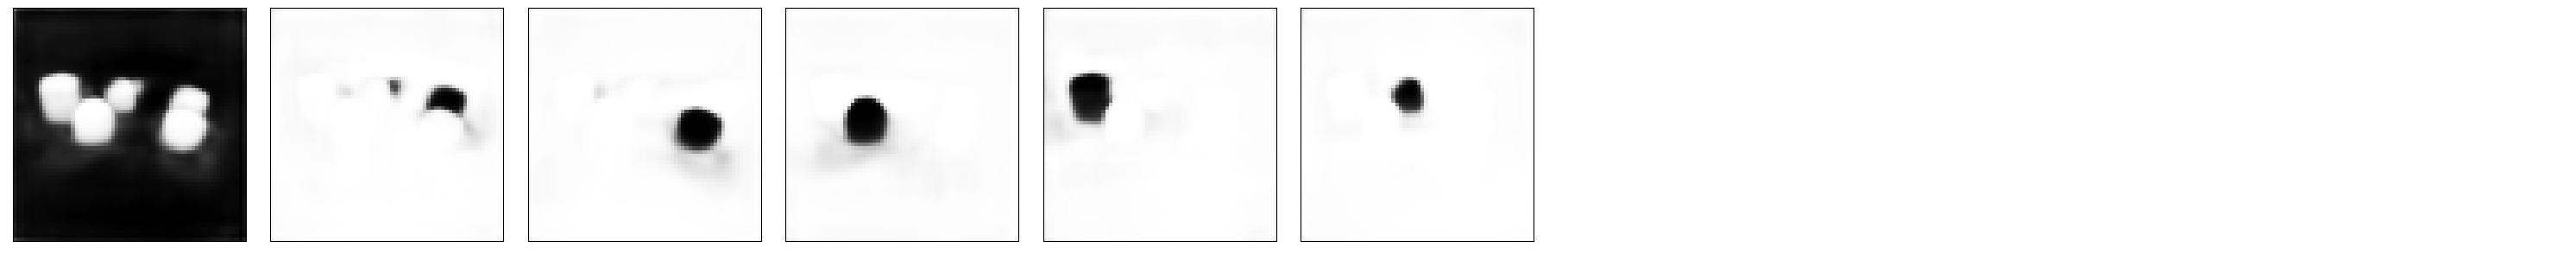

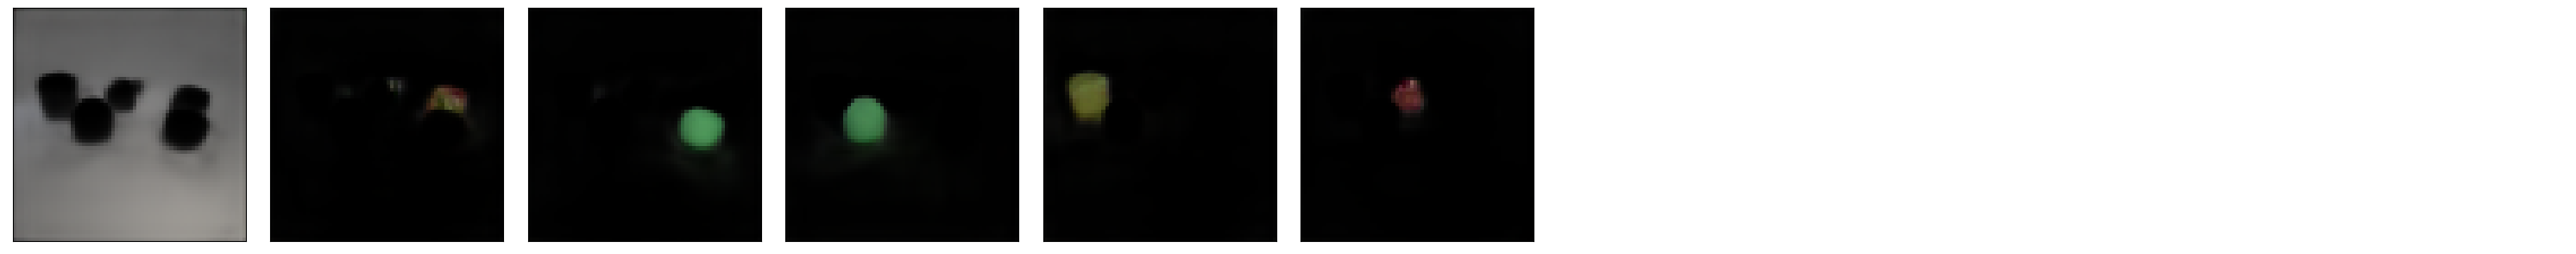

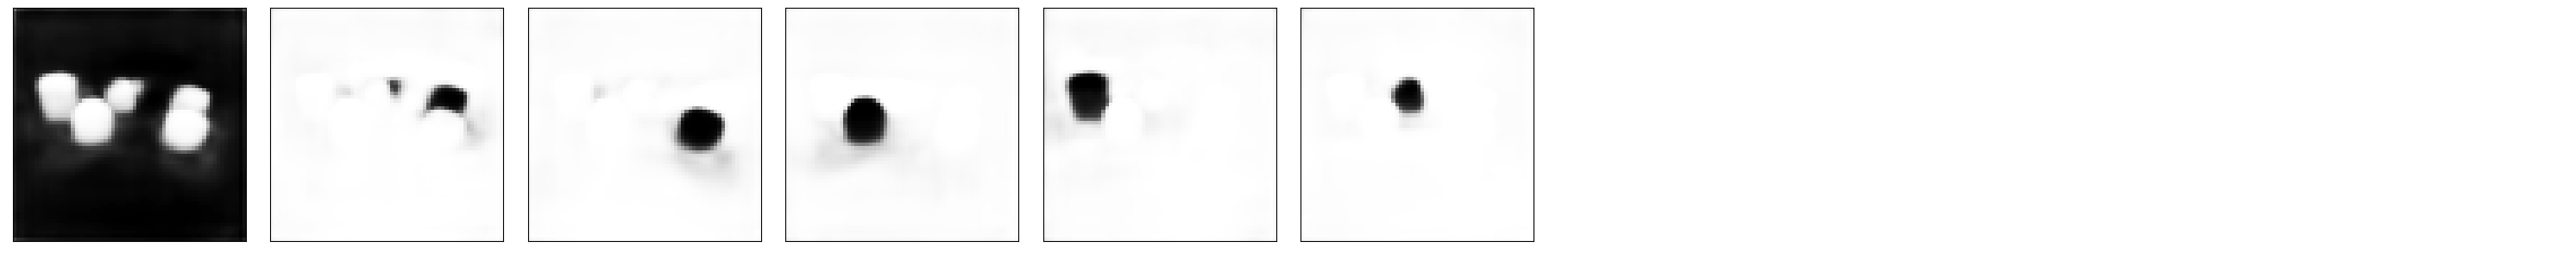

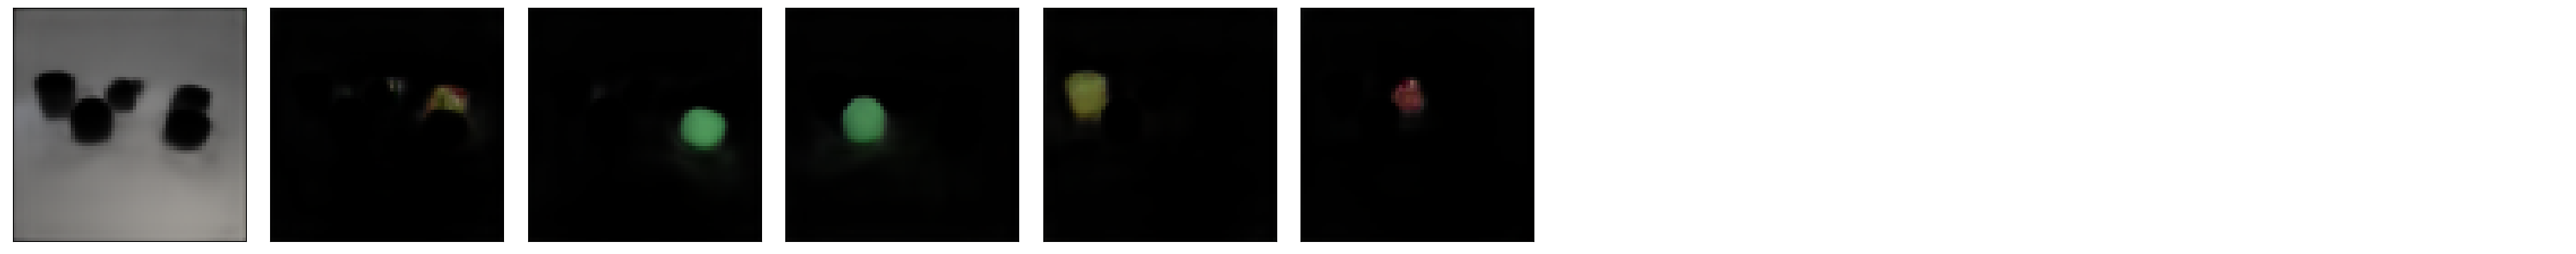

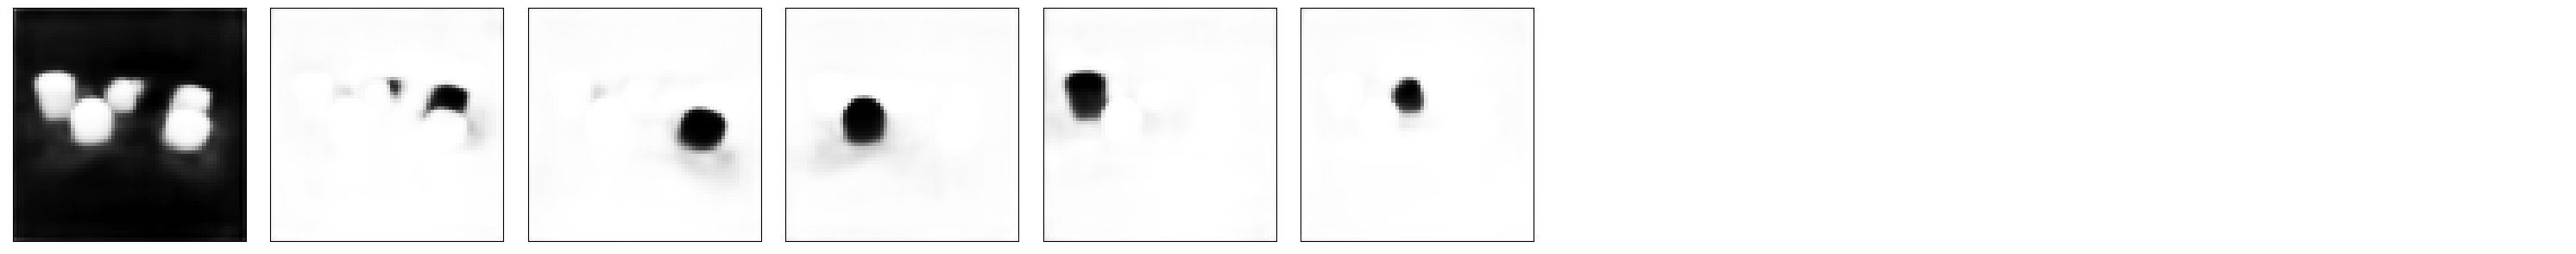

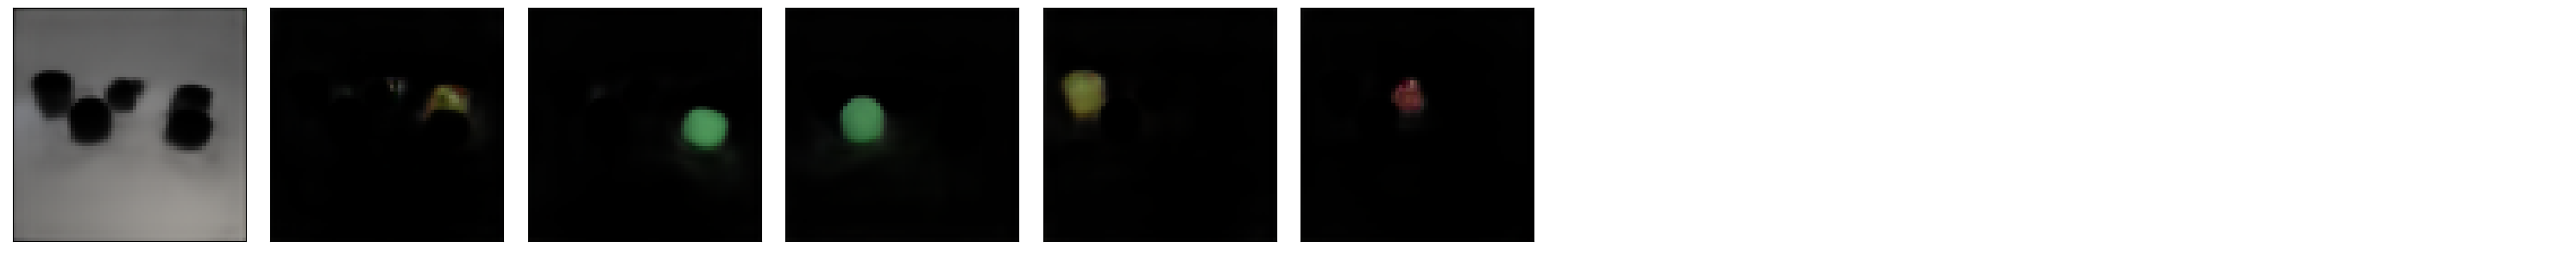

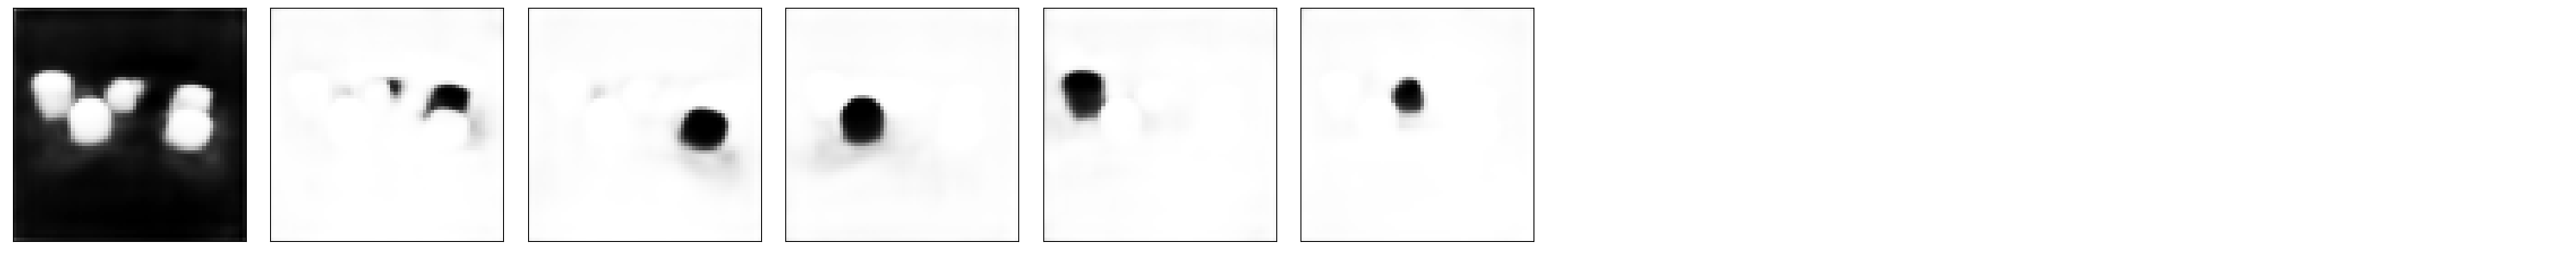

In [52]:
from lib import utils

utils.create_directory("__aux")

for i in range(pred_recons.shape[0]):
    _ = visualizations.visualize_sequence(pred_recons[i] * pred_masks[i], add_title=False, savepath=os.path.join("__aux", f"rgb_{i+1}.png"))
    _ = visualizations.visualize_sequence(pred_masks[i], cmap="gray_r", add_title=False, savepath=os.path.join("__aux", f"mask_{i+1}.png"))
    # break

In [43]:
pred_recons.shape

torch.Size([25, 6, 3, 64, 64])